# Purpose of the Notebook

# Problem Statement

# Module Import

In [1]:
import os
#uncomment this if you want to run on your CPU instead of GPU
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
import datetime
from collections import Counter
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

#to speed up pandas operands
from pandarallel import pandarallel

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, classification_report
from sklearn.metrics import confusion_matrix

import nltk
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GlobalAveragePooling1D, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, GlobalMaxPooling1D


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model

import tensorflow.keras.utils as ku 

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


import emoji

from project5_utils import my_print
from project5_utils import my_wait

from MyMovieReview import MovieReview
from MyMovieReview import MovieReviewGenerator

from mymovie import Movie

In [2]:
print("tensorflow version is {}".format(tensorflow.__version__))
print("keras version is {}".format(keras.__version__))


tensorflow version is 2.2.0
keras version is 2.3.0-tf


In [3]:
%matplotlib inline 

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/magreen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
nltk.download('words')

[nltk_data] Downloading package words to /home/magreen/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [57]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/magreen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [63]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/magreen/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [65]:
 nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/magreen/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [30]:
LOG_FILE = open("../Data/notebook.log","w")
DEBUG = 1

In [31]:
#Setting these for now will adjust them
VOCAB_SIZE = 400000
BASELINE_EMBEDDING_DIM = 32
GLOVE_EMBEDDING_DIM = 100
#will calc this based on training set
#MAX_LENGTH = 1000
TRUC_TYPE = "post"
PAD_TYPE = "post"
#Out of Value Token -- or token to indicate a 
OOV_TOK = "<OOV>"

TRAIN_SET_PERCENT =  90.0
EPOCHS = 100
RANDOM_STATE = 42

BATCH_SIZE = 96

In [32]:
tensorflow.random.set_seed(RANDOM_STATE)

# Data Processing
Get reviews from PKL files into format that can be tokenized

In [33]:
MOVIE_REVIEWS_PKL_FILE = open("../Data/Reviews_back15.pkl","rb")

list_of_movie_reviews = []

while 1:
    try:
        temp_review = pickle.load(MOVIE_REVIEWS_PKL_FILE)
        list_of_movie_reviews.append(temp_review)
        my_print("added this review to the list ==>\n{}\n".format(temp_review), DEBUG, LOG_FILE)
    except EOFError:
        my_print("DONE reading movie reviews", DEBUG, LOG_FILE)
        break
        
MOVIE_REVIEWS_PKL_FILE.close()
print("Number of movie reviews read: {}".format(len(list_of_movie_reviews)))

Number of movie reviews read: 74461


In [34]:
col_names = list(list_of_movie_reviews[0].__dict__.keys())
#col_values = list(list_of_movie_reviews[0].__dict__.values()) --> TODO: REMOVE

In [35]:
list_of_movie_review_lists = []

for review_col_name in col_names:
    list_of_movie_review_data_vals = []
    
    for review_obj in list_of_movie_reviews:
        list_of_movie_review_data_vals.append ( review_obj.__dict__[review_col_name] )
        
    list_of_movie_review_lists.append(list_of_movie_review_data_vals)
    
reviews_dict = dict(zip(col_names,list_of_movie_review_lists))
reviews_df = pd.DataFrame(reviews_dict)
reviews_df.head()

,review_text,review_star_rating,reviewer_name,directlink_url,reviewlink_url,title,review_title,review_date
0,At the end of this movie there's a shot of the...,2,veardleyw,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4675276/,On the Basis of Sex,"Feeble, telemovie-style travesty of a potentia...",20 February 2019
1,The film starts in 1956 with RBG (Felicity Jon...,8,nogodnomasters,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4783407/,On the Basis of Sex,It's not a movement if everyone is just sitting.,15 April 2019
2,This well meaning movie shows the discriminati...,5,phd_travel,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4590175/,On the Basis of Sex,Well intentioned but miscast,18 January 2019
3,Why would you make a movie about the second fe...,1,Viking131313,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4621289/,On the Basis of Sex,Makes no sense.,2 February 2019
4,This movie was very well done. Good acting and...,10,MikeChm,http://www.imdb.com/title/tt4669788/,http://www.imdb.com/review/rw4583636/,On the Basis of Sex,Well worth going to see!,15 January 2019


**CLEANING**



In [36]:
#Get rid of instances of people spamming the same review
reviews_df.drop_duplicates(subset=["review_text"],keep="first",inplace=True)

In [37]:
#Get rid of reviews where "review_star_rating" is missing or "review_text" is missing
mask = (reviews_df["review_text"] == "EMPTY") | (reviews_df["review_star_rating"] == -1)
mask_keep = ~mask

In [38]:
reviews_df = reviews_df[mask_keep]

In [39]:
reviews_df.dropna(inplace=True)

In [40]:
reviews_df.shape

(74316, 8)

In [41]:
text_of_reviews = reviews_df[["review_title","review_text","review_star_rating"]]

Text corpus will be composed of the review title concatenated with the review text

In [42]:
text_of_reviews["review_observation"] = text_of_reviews["review_title"] + " " + text_of_reviews["review_text"]

<ipython-input-42-b4d769d80be9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_of_reviews["review_observation"] = text_of_reviews["review_title"] + " " + text_of_reviews["review_text"]


In [43]:
text_of_reviews = text_of_reviews.rename(columns={"review_text":"review_text_original"})

In [44]:
text_of_reviews = text_of_reviews.rename(columns= {"review_observation":"review_text"})

In [45]:
text_of_reviews.head()

,review_title,review_text_original,review_star_rating,review_text
0,"Feeble, telemovie-style travesty of a potentia...",At the end of this movie there's a shot of the...,2,"Feeble, telemovie-style travesty of a potentia..."
1,It's not a movement if everyone is just sitting.,The film starts in 1956 with RBG (Felicity Jon...,8,It's not a movement if everyone is just sittin...
2,Well intentioned but miscast,This well meaning movie shows the discriminati...,5,Well intentioned but miscast This well meaning...
3,Makes no sense.,Why would you make a movie about the second fe...,1,Makes no sense. Why would you make a movie abo...
4,Well worth going to see!,This movie was very well done. Good acting and...,10,Well worth going to see! This movie was very w...


**Some Statistics**
* Are the classes balanced?
* What's the mean, mode, stddev of the classes?
* Length of reviews: mean, mode, std dev, and all of this for each class

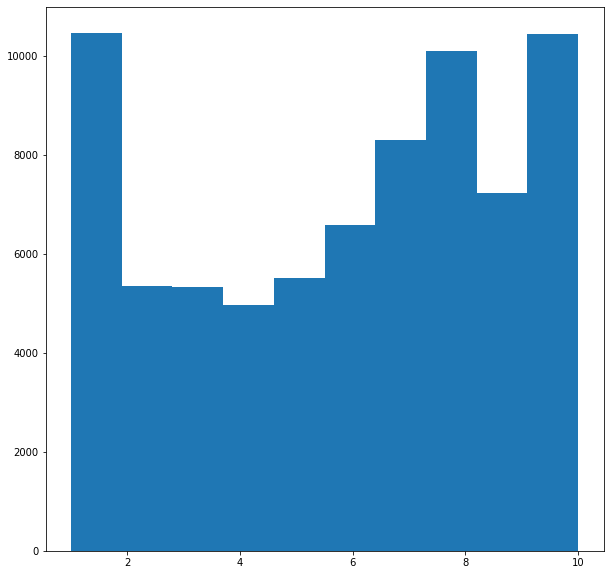

In [46]:
plt.figure(figsize=(10,10))
plt.hist(text_of_reviews["review_star_rating"],10);

In [47]:
text_of_reviews.describe()

,review_star_rating
count,74316.000000
mean,5.821936
std,3.067538
min,1.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,10.000000


In [48]:
text_of_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74316 entries, 0 to 74460
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   review_title          74316 non-null  object
 1   review_text_original  74316 non-null  object
 2   review_star_rating    74316 non-null  int64 
 3   review_text           74316 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [49]:
len(text_of_reviews)

74316

In [50]:
median = text_of_reviews["review_star_rating"].median()
mode = text_of_reviews["review_star_rating"].mode()

print("median = ", median)
print("mode = ", mode)

#mode = text_of_reviews["review_star_rating"].mode(axis=1)

median =  6.0
mode =  0    1
dtype: int64


In [51]:
text_of_reviews["review_star_rating"].value_counts()

1     10469
10    10443
8     10104
7      8313
9      7230
6      6585
5      5507
2      5348
3      5338
4      4979
Name: review_star_rating, dtype: int64

Just some thoughts: I have alot of very good and very bad reviews. Not a lot of 2,3,4,5,6's. I'm worried the precision of the model is going to suffer and it will just be a binary classifier.
🙁

## Cleaning and Lemmatization
To reduce dimentionality of the corpus


In [52]:
def remove_html_punct(row):
    """This function removes HTML and punctuation and anything that is or contains a number from the Text"""
    
    NLTK_WORDS = set(nltk.corpus.words.words())
    
    text_to_process = row["review_text"]
    text_to_process = text_to_process.lower()
    text_to_process = re.sub("<.*?>","",text_to_process)
    text_to_process = re.sub("[\.|\!|\?|\,|\;|\:|\&|\(|\)|\-|\%|_|\#|\$|\*|\+|\/|\=|\[|\]|\^|\`|\{|\}|\~]","",text_to_process)
    text_to_process = re.sub("\w*\d+\w*","",text_to_process)
    text_to_process_list = text_to_process.split()
    text_to_process_list = [review_word for review_word in text_to_process_list if review_word in NLTK_WORDS]
    text_to_process = " ".join(text_to_process_list)
    return text_to_process

In [53]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(remove_html_punct, axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:15:05.979626


In [54]:
text_of_reviews["review_text"] = text_of_reviews["review_text"].apply(lambda x : x.lower())

In [55]:
def tokenize_text(row):
    temp_tokenized_txt = word_tokenize(row["review_text"])
    return temp_tokenized_txt


In [58]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(tokenize_text,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:12.863955


In [59]:
wordNetLemmatizer = WordNetLemmatizer()

In [60]:
def calc_partofspeech(raw_pos):
    """translates from POS generated by pos_tag() to a POS encoding that WordNetLemmatizer.lemmatize() understands"""
    #print("word = ",word)
    #[(output_word, output_pos)] = pos_tag(word_tokenize(word))
    
    #decode output_pos to the pos required by the lemmatizer
    
    if "JJ" in raw_pos:
        pos = "a"
    elif "RB" in raw_pos:
        pos = "r"
    elif "VB" in raw_pos:
        pos = "v"
    else:
        pos = "n"
    
    return pos

In [61]:
def lemmatize_it(row):
    
    pos_result = pos_tag(row["review_text"])
    
    temp_mydoc_lemmatized = []
    
    for myword,myPOS in pos_result:
        temp_word_lemmatized = wordNetLemmatizer.lemmatize(myword,calc_partofspeech(myPOS))
        temp_mydoc_lemmatized.append(temp_word_lemmatized)
    
    return temp_mydoc_lemmatized
        


In [66]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["review_text"] = text_of_reviews.parallel_apply(lemmatize_it,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:54.315102


In [67]:
pandarallel.initialize()
start_time = datetime.datetime.now()
text_of_reviews["review_text"]  = text_of_reviews.parallel_apply(lambda x : " ".join(x["review_text"]), axis=1)
end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:07.936417


## Stop word removal
Should I do it?

It lowers dimensionality which can improve training time.

But for a sequence model won't removing the stop words hurt the ability of the model to learn sequences that may be indicative of a specific class? In this project I need pretty high precision because I have 10 categories to classify based on text.

Some stuff I've read:

**Pro or Con**:

* https://stackoverflow.com/questions/37325914/should-i-remove-stopwords-when-feed-sentence-to-rnn
* https://www.quora.com/Is-text-preprocessing-e-g-stop-words-removing-still-necessary-in-neural-based-NLP
* https://www.quora.com/Is-text-preprocessing-e-g-stop-words-removing-still-necessary-in-neural-based-NLP

Reading the last link I think I should keep the stop words. The star rating applied to a reviews is a form of sentiment about the review. If a reviewer says "I was not happy with the ending of the movie," stop word removal may convert that to "happy movie ending". This may result in two reviews containing the words "happy movie ending": One with a review of 2 and another with a review of 8 with the original text for the latter score being "I was happy with the ending of the movie."

So will not do stop word removal for now but will keep in as an option if results seem to call for it.


## Converting Star Rating To Net Promoter Score
See https://www.netpromoter.com/know/ for more details

In [68]:
#shifting range of ratings from 1,10 to 0,9
text_of_reviews["review_star_rating"] = text_of_reviews["review_star_rating"] - 1

In [69]:
def gen_net_promoter(row):
    if row["review_star_rating"] <= 6:
        #Detractor
        return 0
    elif row["review_star_rating"] <= 8:
        #Passive
        return 1
    else:
        ##Promotor
        return 2

In [70]:
pandarallel.initialize()
start_time = datetime.datetime.now()

text_of_reviews["net_promoter_score"] = text_of_reviews.parallel_apply(gen_net_promoter,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:02.697042


In [71]:
text_of_reviews.shape

(74316, 5)

In [72]:
text_of_reviews["net_promoter_score"].value_counts()

0    46539
1    17334
2    10443
Name: net_promoter_score, dtype: int64

In [73]:
text_of_reviews.head()

,review_title,review_text_original,review_star_rating,review_text,net_promoter_score
0,"Feeble, telemovie-style travesty of a potentia...",At the end of this movie there's a shot of the...,1,feeble travesty of a potentially fascinating s...,0
1,It's not a movement if everyone is just sitting.,The film starts in 1956 with RBG (Felicity Jon...,7,not a movement if everyone be just sit the fil...,1
2,Well intentioned but miscast,This well meaning movie shows the discriminati...,4,well intentioned but miscast this well mean mo...,0
3,Makes no sense.,Why would you make a movie about the second fe...,0,no sense why would you make a movie about the ...,0
4,Well worth going to see!,This movie was very well done. Good acting and...,9,well worth go to see this movie be very well d...,2


## Train Test Split
Did it this way to preserve indices. I could have done it on the original data frame (TODO).

In [74]:
#Randomizing and doing train test split but preserving indices
train_set_size = int ( ( text_of_reviews.shape[0] * TRAIN_SET_PERCENT ) / 100 )
#test_set_size =  text_of_reviews.shape[0] - train_set_size

review_indices = np.arange(text_of_reviews.shape[0]) 

np.random.seed(RANDOM_STATE)
np.random.shuffle( review_indices)


text_of_reviews = text_of_reviews.iloc[review_indices]

training_indices = review_indices[:train_set_size]
testing_indices = review_indices[train_set_size:]


print(train_set_size)
print(text_of_reviews.shape)
print(training_indices.shape)
print(testing_indices.shape)


66884
(74316, 5)
(66884,)
(7432,)


In [75]:
testing_indices[:3]

array([66902, 20707, 40958])

In [76]:
text_of_reviews_np  = np.array(text_of_reviews)

text_test_set = text_of_reviews_np[testing_indices]
text_train_set = text_of_reviews_np[training_indices]
text_test_set.shape, text_train_set.shape

((7432, 5), (66884, 5))

In [77]:
text_test_set[:1]

array([['Entertaining prison movie',
        'No doubt that movie is entertaining, 8/10, fast, no slow time. Humour, jokes, a few reference to older movie. This movie is with both main actor, not a Sly movie with a cameo of Arnold, its both of them all the time. It\'s good and funny. The plot is intelligent, I liked it. It\'s not a remake of any kind, of course you know the end or you can predict some of the turnouts. But, overall it is fun and intelligent. The ending is rushed a bit, turns out like a bit of a sort of "Expendable" style of movie, but not as much. No sex, or any kind of romance in that movie, or super chicks making you want to jump at the screen, it\'s a typical American movie, blood, guns & some violence, but no chick.',
        7,
        'entertain prison movie no doubt that movie be entertain fast no slow time humour a few reference to older movie this movie be with both main actor not a sly movie with a cameo of it both of them all the time good and funny the plot 

In [78]:
print(text_of_reviews.loc[23136,"review_text"])

every minute of this maybe this movie be just not for everyone but especially towards i think every girl who have a broken heart and to watch a fun movie that very true to life will really enjoy this movie i do


In [79]:
text_of_reviews.head()

,review_title,review_text_original,review_star_rating,review_text,net_promoter_score
40297,story disintegrates,Bert Rodriguez (Joseph Gordon-Levitt) is a fas...,2,story be a commentator on star from his baseme...,0
31839,Mediocre Star Vehicle,A competent but paint by numbers example of th...,3,mediocre star vehicle a competent but paint by...,0
35698,Brace yourself for impact...,Actually I had expected this to be somewhat mo...,7,brace yourself for impact actually i have this...,1
67174,Movie dripping with hate.,This movie sticks out like a rancid sore thumb...,1,movie drip with hate this movie stick out like...,0
43188,An indie film without indie charm,"Among many other things, the best dialogue-dri...",4,an film without charm among many other the bes...,0


In [80]:
#spent hours trying to re-implement train_test_split() :*-(

#train_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_text"]
#train_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(training_indices),"review_star_rating"]

#train_text_reviews = text_of_reviews.sample(n=train_set_size, random_state=RANDOM_STATE, )

#test_new_reviews = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_text"]
#test_new_reviews_rating = text_of_reviews.loc[text_of_reviews.index.intersection(testing_indices),"review_star_rating"]

#X = text_of_reviews["review_text"]
#y = text_of_reviews["review_star_rating"]

X_test = text_test_set[:,3]
X_train = text_train_set[:,3]
y_test = text_test_set[:,4]
y_train = text_train_set[:,4]
y_test = y_test.astype("int")
y_train = y_train.astype("int")


Test_Size = 1.0 - (TRAIN_SET_PERCENT/100.0)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Test_Size, random_state=RANDOM_STATE)


In [81]:
#TODO
#Lemmatization
#stop word removal
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(66884,)
(66884,)
(7432,)
(7432,)


In [82]:
Max_Length = max([len(doc) for doc in X_train])
print("Max_Length = {}".format(Max_Length))
CONSTANTS_FILE = open("../Data/constants.pkl","wb")
CONSTANTS = [TRUC_TYPE, PAD_TYPE, OOV_TOK,Max_Length]
pickle.dump(CONSTANTS, CONSTANTS_FILE)
CONSTANTS_FILE.close()

Max_Length = 7779


## Tokenization and Sequence Padding

In [83]:
tokenizer = Tokenizer(oov_token=OOV_TOK, num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
total_words = len(tokenizer.word_index)+1
i = 0
for key, value in tokenizer.word_index.items():
    
    if i == 10:
        break
        
    print("word_index[{}] = {}".format(key, value))
    i += 1
    
print("\ntotal words is {}".format(total_words))

word_index[<OOV>] = 1
word_index[the] = 2
word_index[be] = 3
word_index[a] = 4
word_index[and] = 5
word_index[to] = 6
word_index[of] = 7
word_index[it] = 8
word_index[in] = 9
word_index[i] = 10

total words is 30126


In [84]:
TOKENIZER_FILE = open("../Data/project5_tokenizer.pkl","wb")
pickle.dump(tokenizer, TOKENIZER_FILE)
TOKENIZER_FILE.close()
my_print("Done writing out tokenizer file",DEBUG,LOG_FILE)

In [85]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_pad = pad_sequences(X_train_seq, maxlen=Max_Length, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [86]:
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_pad = pad_sequences(X_test_seq, maxlen=Max_Length, padding=PAD_TYPE, truncating=TRUC_TYPE)

In [87]:
for i, thing in enumerate(X_train_seq):
    if i == 3:
        break
    print("thing = {}".format(thing))

thing = [4, 206, 1018, 12, 3, 21, 161, 5, 111, 10, 8, 2, 85, 10, 54, 18, 6, 36, 8, 1318, 6, 835, 254, 8, 242, 10, 3, 332, 15, 247, 10, 54, 18, 2, 1617, 8, 3, 4, 258, 42, 8, 3, 4, 42, 7, 1610, 19, 77, 16, 2, 195, 83, 15, 4, 1785, 18, 40, 25, 2, 2, 195, 83, 22, 15, 6, 835, 254, 2, 13, 2, 5, 2, 4943, 24, 3, 1059, 6, 2, 120, 6, 225, 4, 284, 15, 10, 236, 48, 7, 2, 18, 51, 8, 4, 156, 272, 102, 185, 4, 2, 83, 6, 818, 12, 185, 18, 6, 846, 8, 5, 36, 8, 4, 304, 50, 49, 20, 18, 10, 93, 51, 2, 15, 36, 8]
thing = [72, 42, 208, 36, 30, 90, 10, 415, 6, 231, 2, 21, 12, 62, 2, 252, 3, 29, 173, 62, 6, 89, 8, 4, 371, 10, 3, 458, 6, 81, 10, 11, 67, 252, 54, 12, 17, 3, 208, 4, 52, 72, 42, 68, 93, 3, 201, 6, 396, 16, 48, 4, 20, 22, 176, 6, 537, 441, 6, 43, 3, 45, 21, 746, 20, 66, 19, 254, 2, 42, 26, 93, 3, 2, 260, 121, 48, 18, 81, 8, 3, 19, 208, 2, 114, 76, 926, 90, 7, 2, 44, 696, 12, 29, 20, 22, 48, 1093, 99, 68, 10, 100, 32, 279, 58, 7, 9, 12, 5, 2, 78, 8, 3, 237, 224, 41, 62, 89, 8, 44, 7, 10, 61, 18, 89

In [88]:
print(X_train_seq_pad.shape)

(66884, 7779)


In [89]:
#Convert to numpy arrays to work with Tensorflow
X_train_seq_pad = np.array(X_train_seq_pad)
y_train = np.array(y_train)

X_test_seq_pad = np.array(X_test_seq_pad)
y_test = np.array(y_test)



In [90]:
X_train_seq_pad.shape, y_train.shape

((66884, 7779), (66884,))

In [91]:
X_test_seq_pad.shape, y_test.shape

((7432, 7779), (7432,))

In [92]:
X_test_seq_pad[:3]

array([[393, 857,  13, ...,   0,   0,   0],
       [331, 104,  12, ...,   0,   0,   0],
       [ 32, 159, 399, ...,   0,   0,   0]], dtype=int32)

In [93]:
y_test[:3]

array([1, 2, 0])

## Confirming Training/Validation data set has the same distribution as the test set

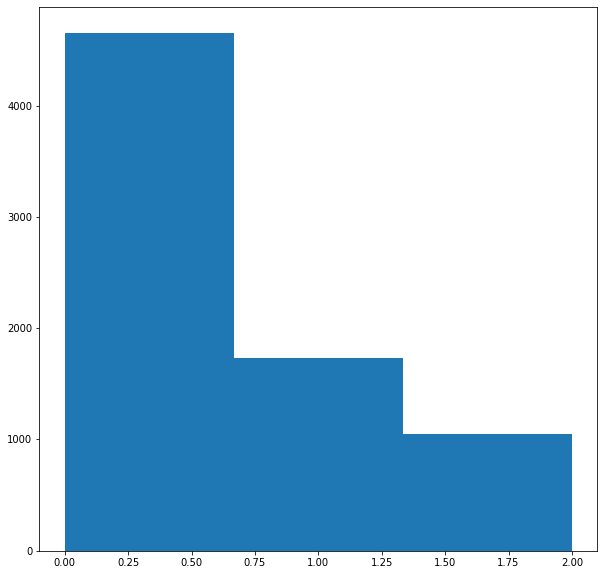

In [94]:
plt.figure(figsize=(10,10))
plt.hist(y_test,3)
plt.show();

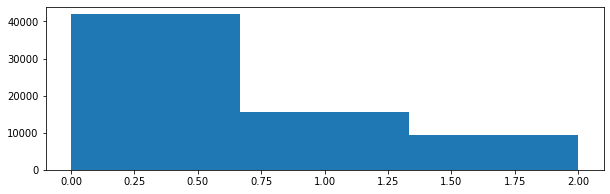

In [95]:
plt.figure(figsize=(10,3))
plt.hist(y_train,3)
plt.show();

Visually the distributions are the same, which I think is important to make sure we are training the model on what it will see in the test set (and hopefully in the wild).

# Baseline Models TODO FIX
The base line model is a custom word embedding providing vectorized words to two layers of 1-D convolutional next networks. According to Chollet a 1-D CNN model can (if properly tuned) do well at text classification.

But the limitation is that if information in the text is highly dependend on the sequence of words, it will be limited. I think because sentiment in English can be highly determined not only by the words used but by the order in which they're used this model won't score well, but is a baseline of how well a simpler-to-train option could do.

TODO: add Reference quoting Chollet

In [96]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("vocab_size is {}".format(vocab_size))

vocab_size is 30126


In [97]:
target_names = list(range(3))
target_names = [str(thing+1) for thing in target_names]


In [98]:
#sorted(sklearn.metrics.SCORERS.keys())

## Random Forest Baseline

In [99]:
########################################################################
##
## TODO: UNCOMMENT THIS AS ANOTHER BASELINE MODEL BEFORE FINAL CHECK IN
##
########################################################################
rf_baseline_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=32)
kfold_obj = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rf_baseline_cv_results = cross_validate(rf_baseline_model, X_train_seq_pad, y_train, cv=kfold_obj, n_jobs=32)
rf_baseline_model.fit(X_train_seq_pad, y_train)

RandomForestClassifier(n_jobs=32, random_state=42)

In [100]:
rf_baseline_cv_results

{'fit_time': array([121.88719988, 125.46974587, 120.61021304, 103.09887314,
         87.14777017]),
 'score_time': array([0.83290386, 0.35163379, 1.7702775 , 5.27303958, 2.26398039]),
 'test_score': array([0.62816775, 0.62114076, 0.62532705, 0.63041041, 0.62507476])}

In [101]:
y_pred_rf = rf_baseline_model.predict(X_test_seq_pad)


In [102]:
y_pred_rf[:3]

array([0, 0, 0])

In [103]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_rf, target_names=target_names))

              precision    recall  f1-score   support

           1       0.63      1.00      0.77      4651
           2       0.00      0.00      0.00      1736
           3       0.00      0.00      0.00      1045

    accuracy                           0.63      7432
   macro avg       0.21      0.33      0.26      7432
weighted avg       0.39      0.63      0.48      7432



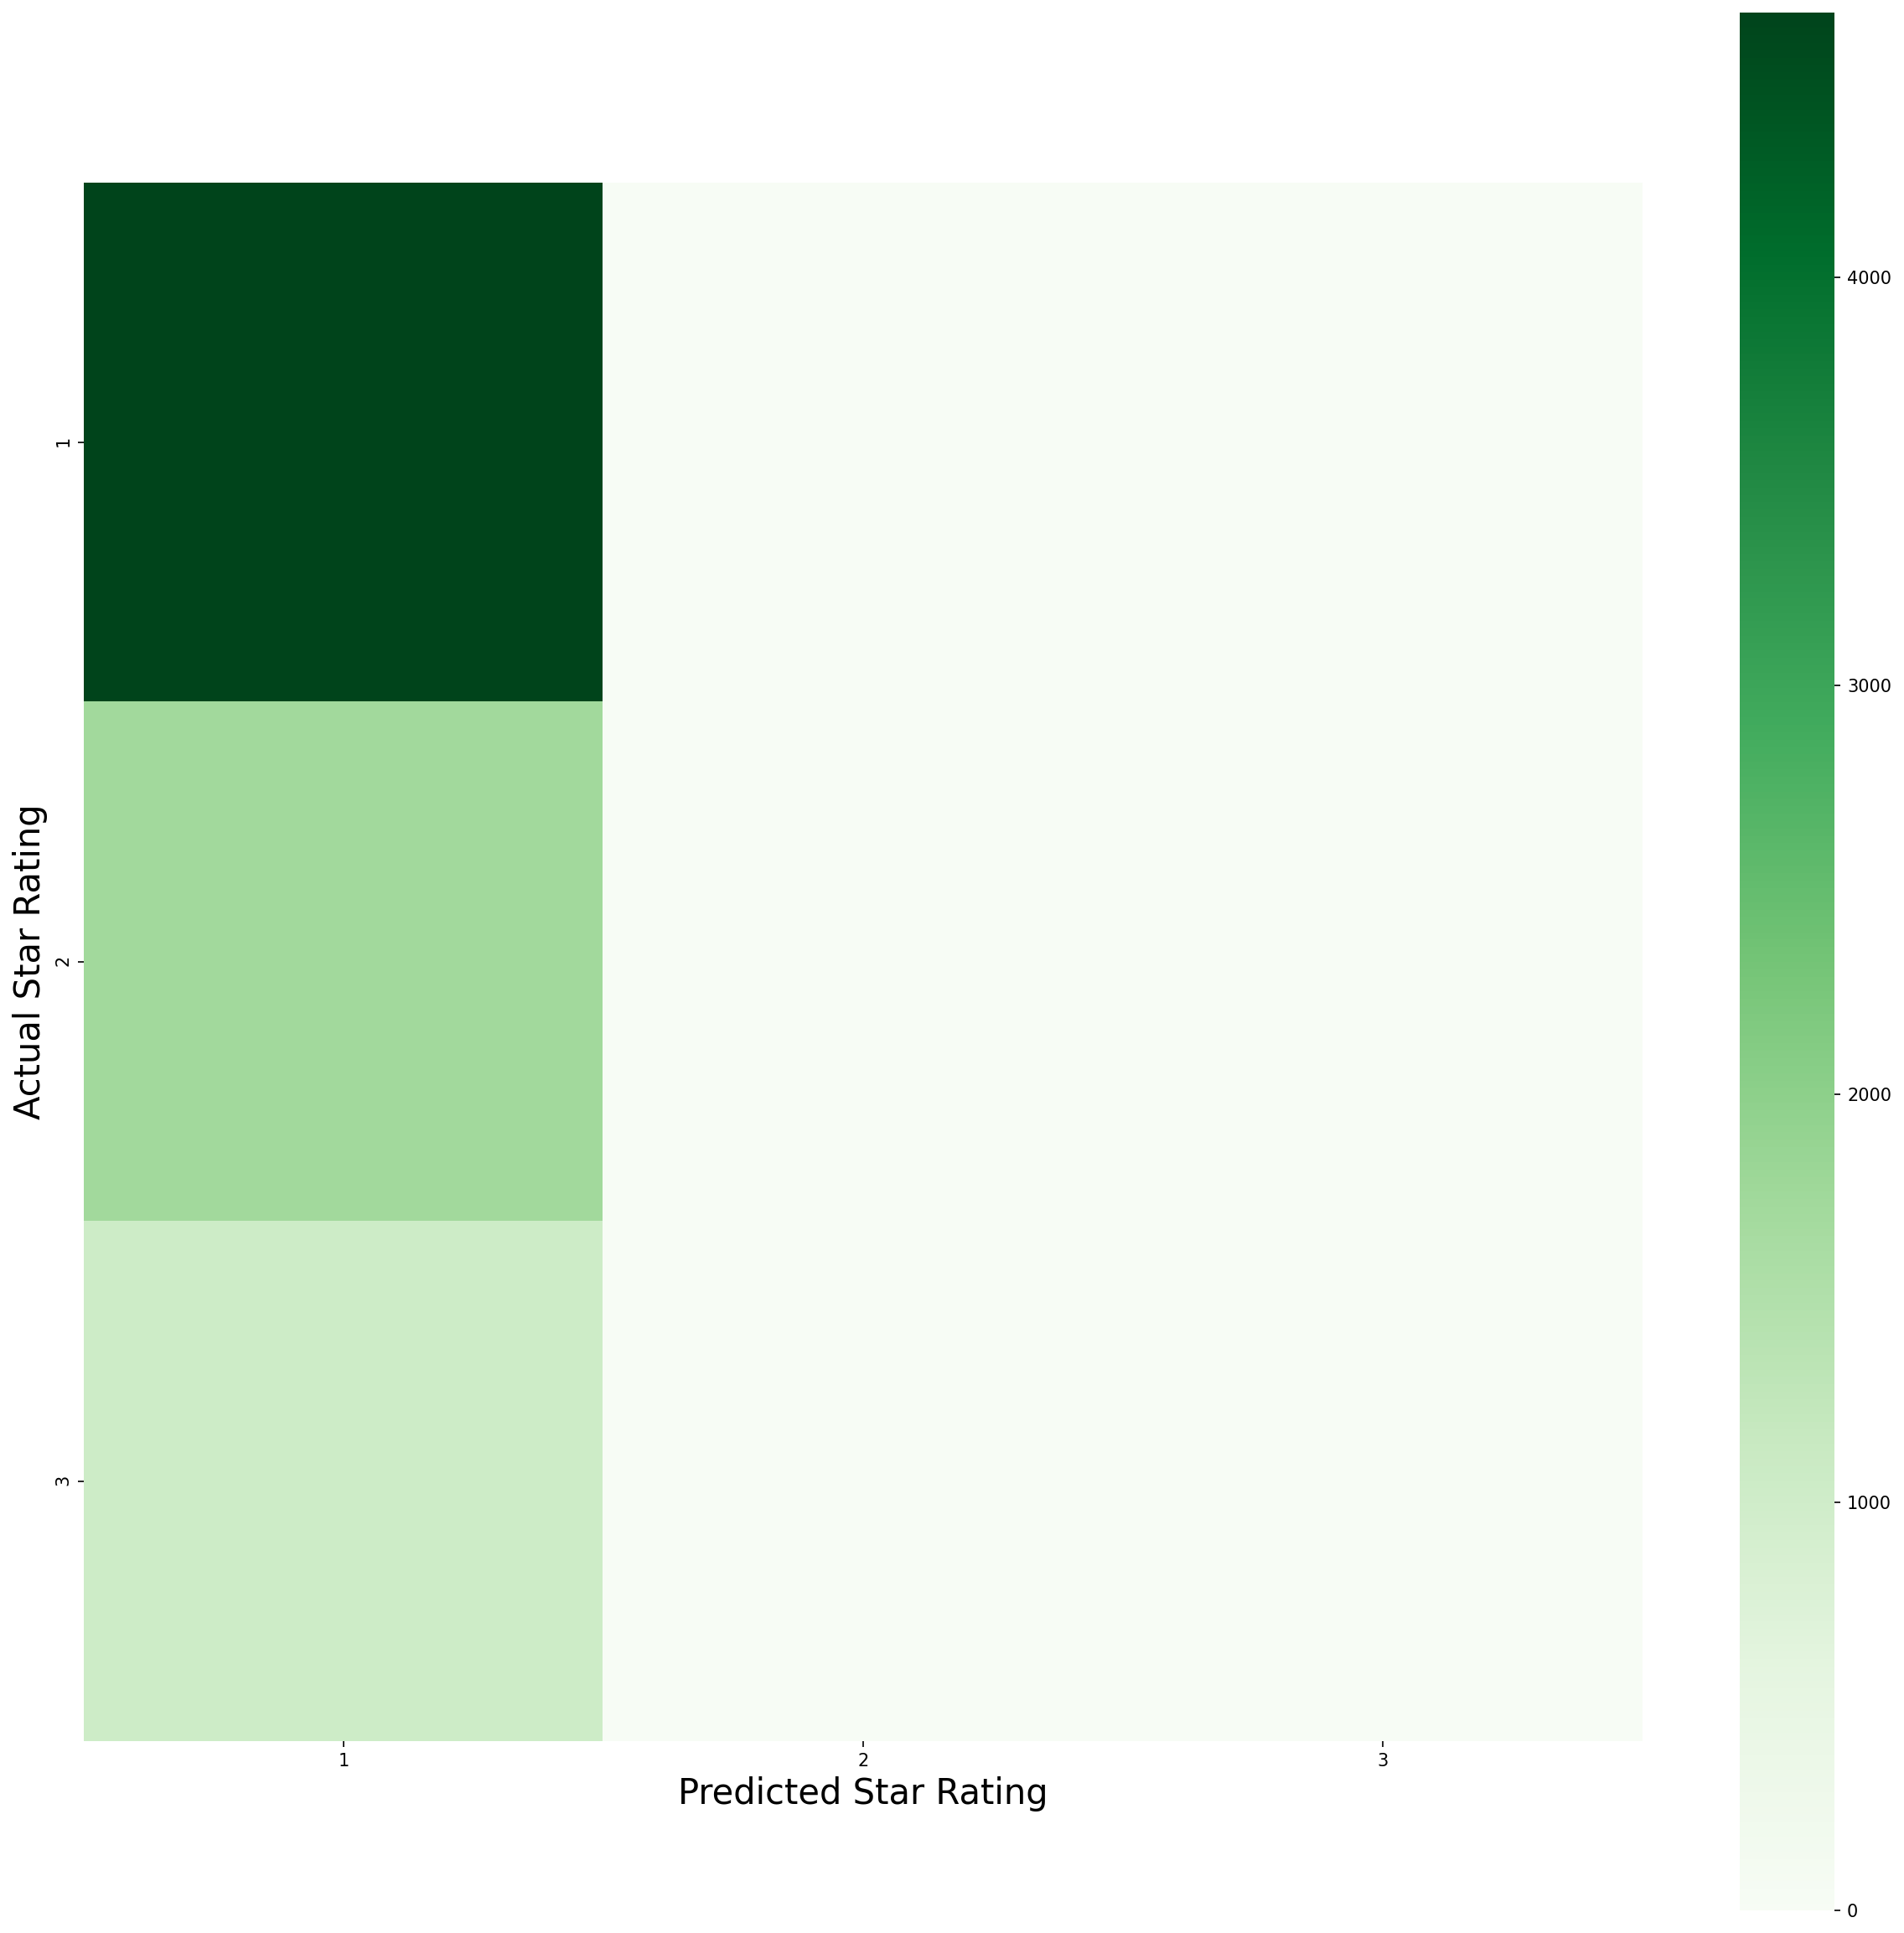

In [104]:
rf_confusion = confusion_matrix(y_test, y_pred_rf)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(rf_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)

plt.savefig("../Documents/Images/rf_confusion_matrix.png",dpi=400);

## CNN Baseline

**Class Weights**

In [105]:
base_model_class_weights_dict = {0:1, 1: 2.31, 2:2.31, 3:2.46, 4:2.309, 5:1.91, 6:1, 7:1, 8:1, 9:1}

In [106]:
tensorflow.keras.backend.clear_session()


In [107]:
baseline_model = Sequential()
baseline_model.add(Embedding(vocab_size, BASELINE_EMBEDDING_DIM, input_length=Max_Length))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(MaxPooling1D(5))
baseline_model.add(Conv1D(32,7,activation="relu"))
baseline_model.add(GlobalMaxPooling1D())
baseline_model.add(Dense(15, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
baseline_model.add(Dropout(0.2))
baseline_model.add(Dense(3, activation="softmax", kernel_regularizer=regularizers.l2(0.001)))

my_adam_optimizer = Adam(lr=0.01)

baseline_model.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7779, 32)          964032    
_________________________________________________________________
conv1d (Conv1D)              (None, 7773, 32)          7200      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1554, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1548, 32)          7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 15)                495       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0

In [108]:
call_back_list = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/baseline_model.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 3
    ),
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [109]:
training_history = baseline_model.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list,
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/100
628/628 [==============================] - 71s 113ms/step - loss: 0.7139 - acc: 0.6756 - val_loss: 0.8646 - val_acc: 0.5522 - lr: 0.0100
Epoch 2/100
628/628 [==============================] - 40s 64ms/step - loss: 0.6151 - acc: 0.7153 - val_loss: 0.6240 - val_acc: 0.7149 - lr: 0.0100
Epoch 3/100
628/628 [==============================] - 40s 64ms/step - loss: 0.5477 - acc: 0.7454 - val_loss: 0.6721 - val_acc: 0.6804 - lr: 0.0100
Epoch 4/100
628/628 [==============================] - 39s 62ms/step - loss: 0.5134 - acc: 0.7558 - val_loss: 0.7223 - val_acc: 0.7098 - lr: 0.0100
Epoch 5/100
628/628 [==============================] - 39s 62ms/step - loss: 0.4764 - acc: 0.7701 - val_loss: 0.7032 - val_acc: 0.6677 - lr: 0.0100
Epoch 6/100
628/628 [==============================] - 39s 62ms/step - loss: 0.3883 - acc: 0.8179 - val_loss: 0.8484 - val_acc: 0.7053 - lr: 1.0000e-03
Epoch 7/100
628/628 [==============================] - 39s 62ms/step - loss: 0.3487 - acc: 0.8437 - val_los

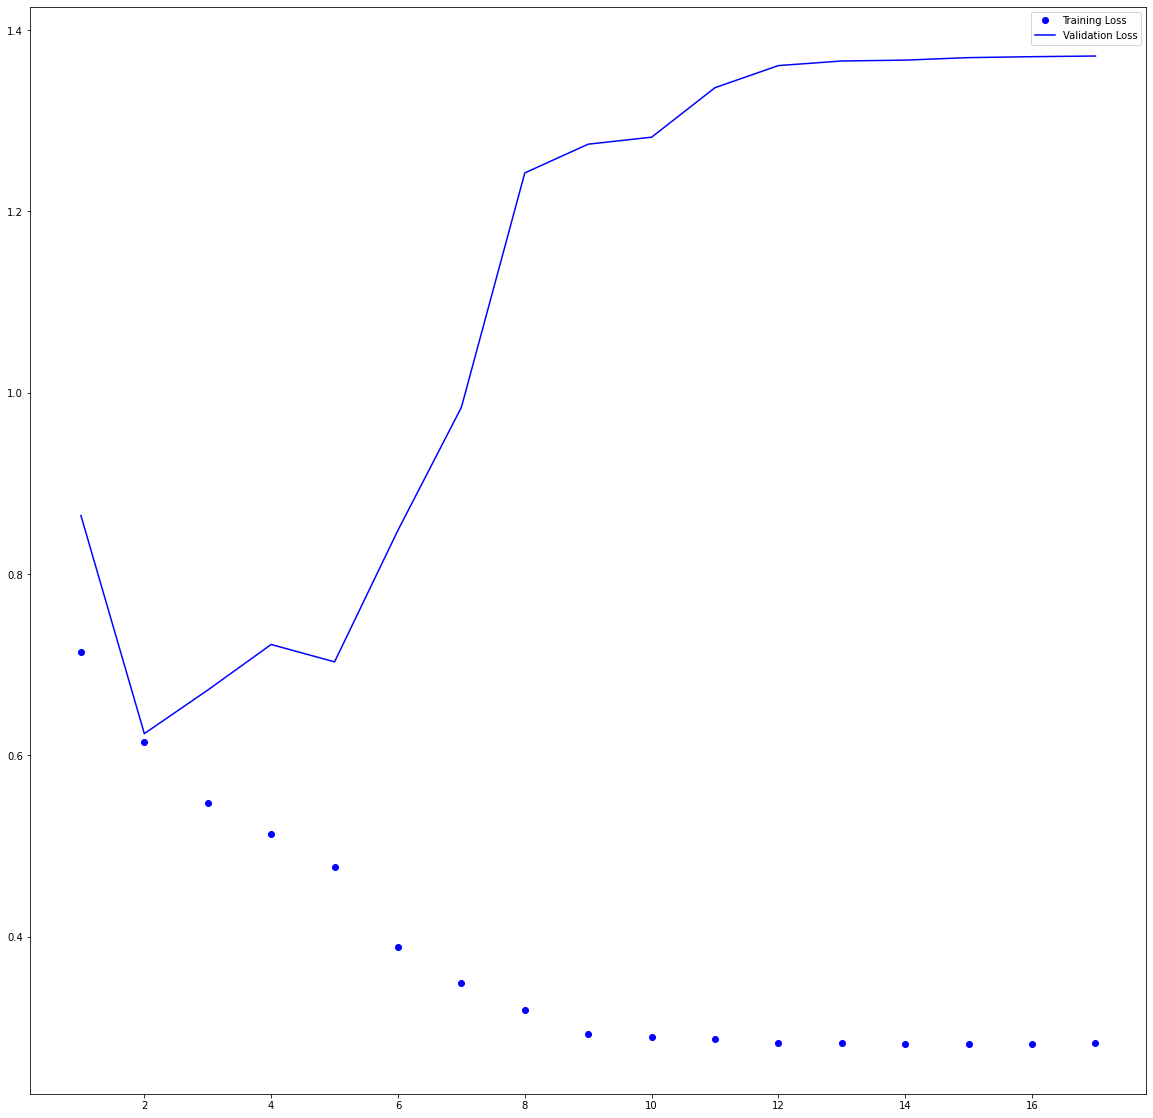

In [110]:
loss = training_history.history["loss"]
val_loss = training_history.history["val_loss"]
acc = training_history.history["acc"]
val_acc = training_history.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/loss_curves.png",dpi=400)


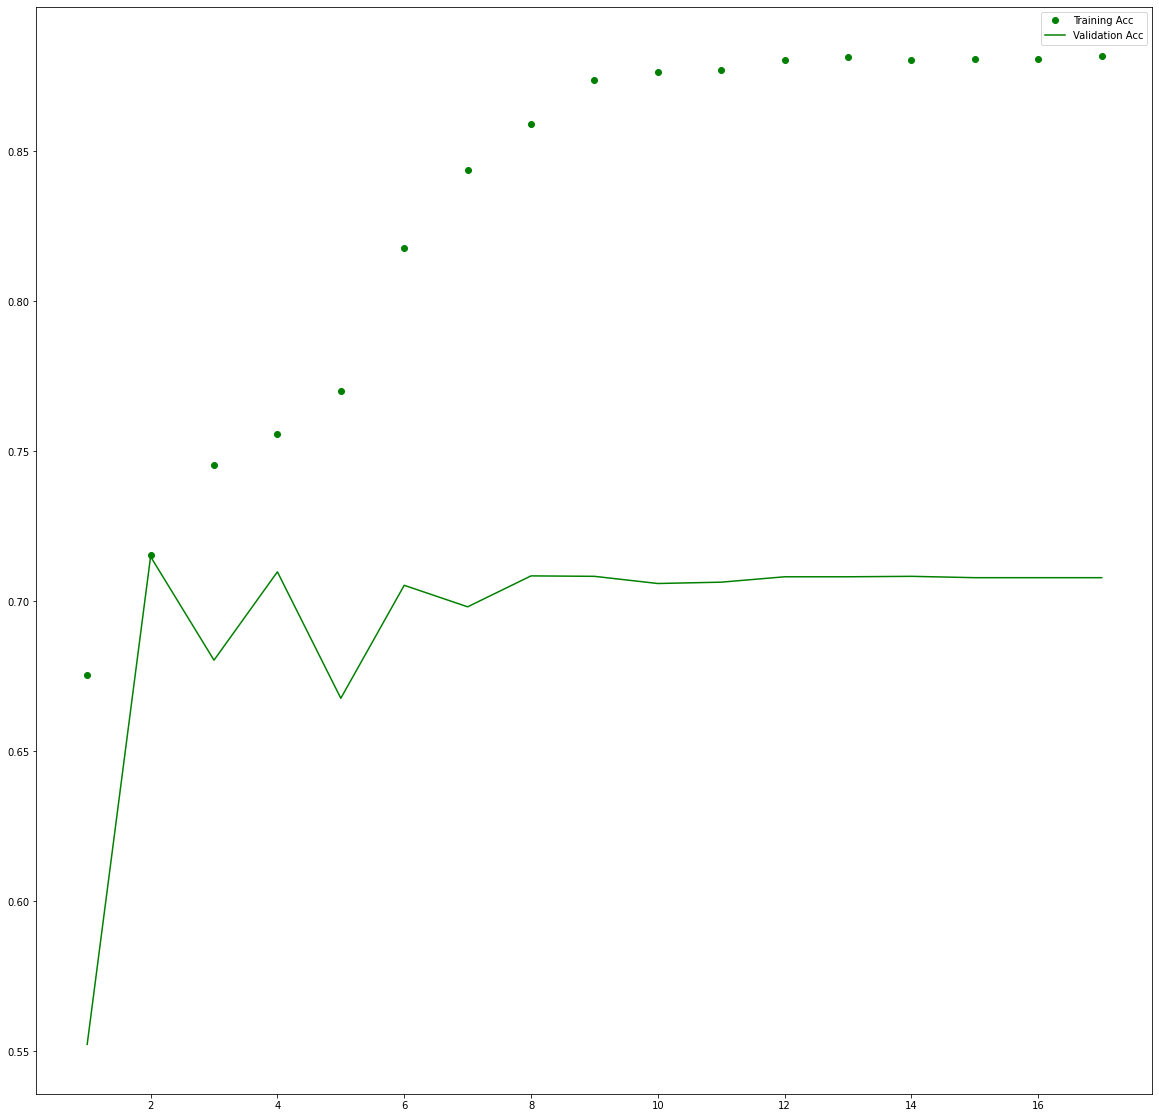

In [111]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/accuracy_curves.png",dpi=400)

In [112]:
y_pred_baseline = baseline_model.predict(X_test_seq_pad)
y_pred_baseline = [np.argmax(y_thing) for y_thing in y_pred_baseline]


In [113]:
#target_names = list(range(10))
#target_names = [str(thing+1) for thing in target_names]


In [114]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

              precision    recall  f1-score   support

           1       0.84      0.90      0.87      4651
           2       0.45      0.63      0.53      1736
           3       0.00      0.00      0.00      1045

    accuracy                           0.71      7432
   macro avg       0.43      0.51      0.46      7432
weighted avg       0.63      0.71      0.67      7432



/home/magreen/anaconda3/envs/project5_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


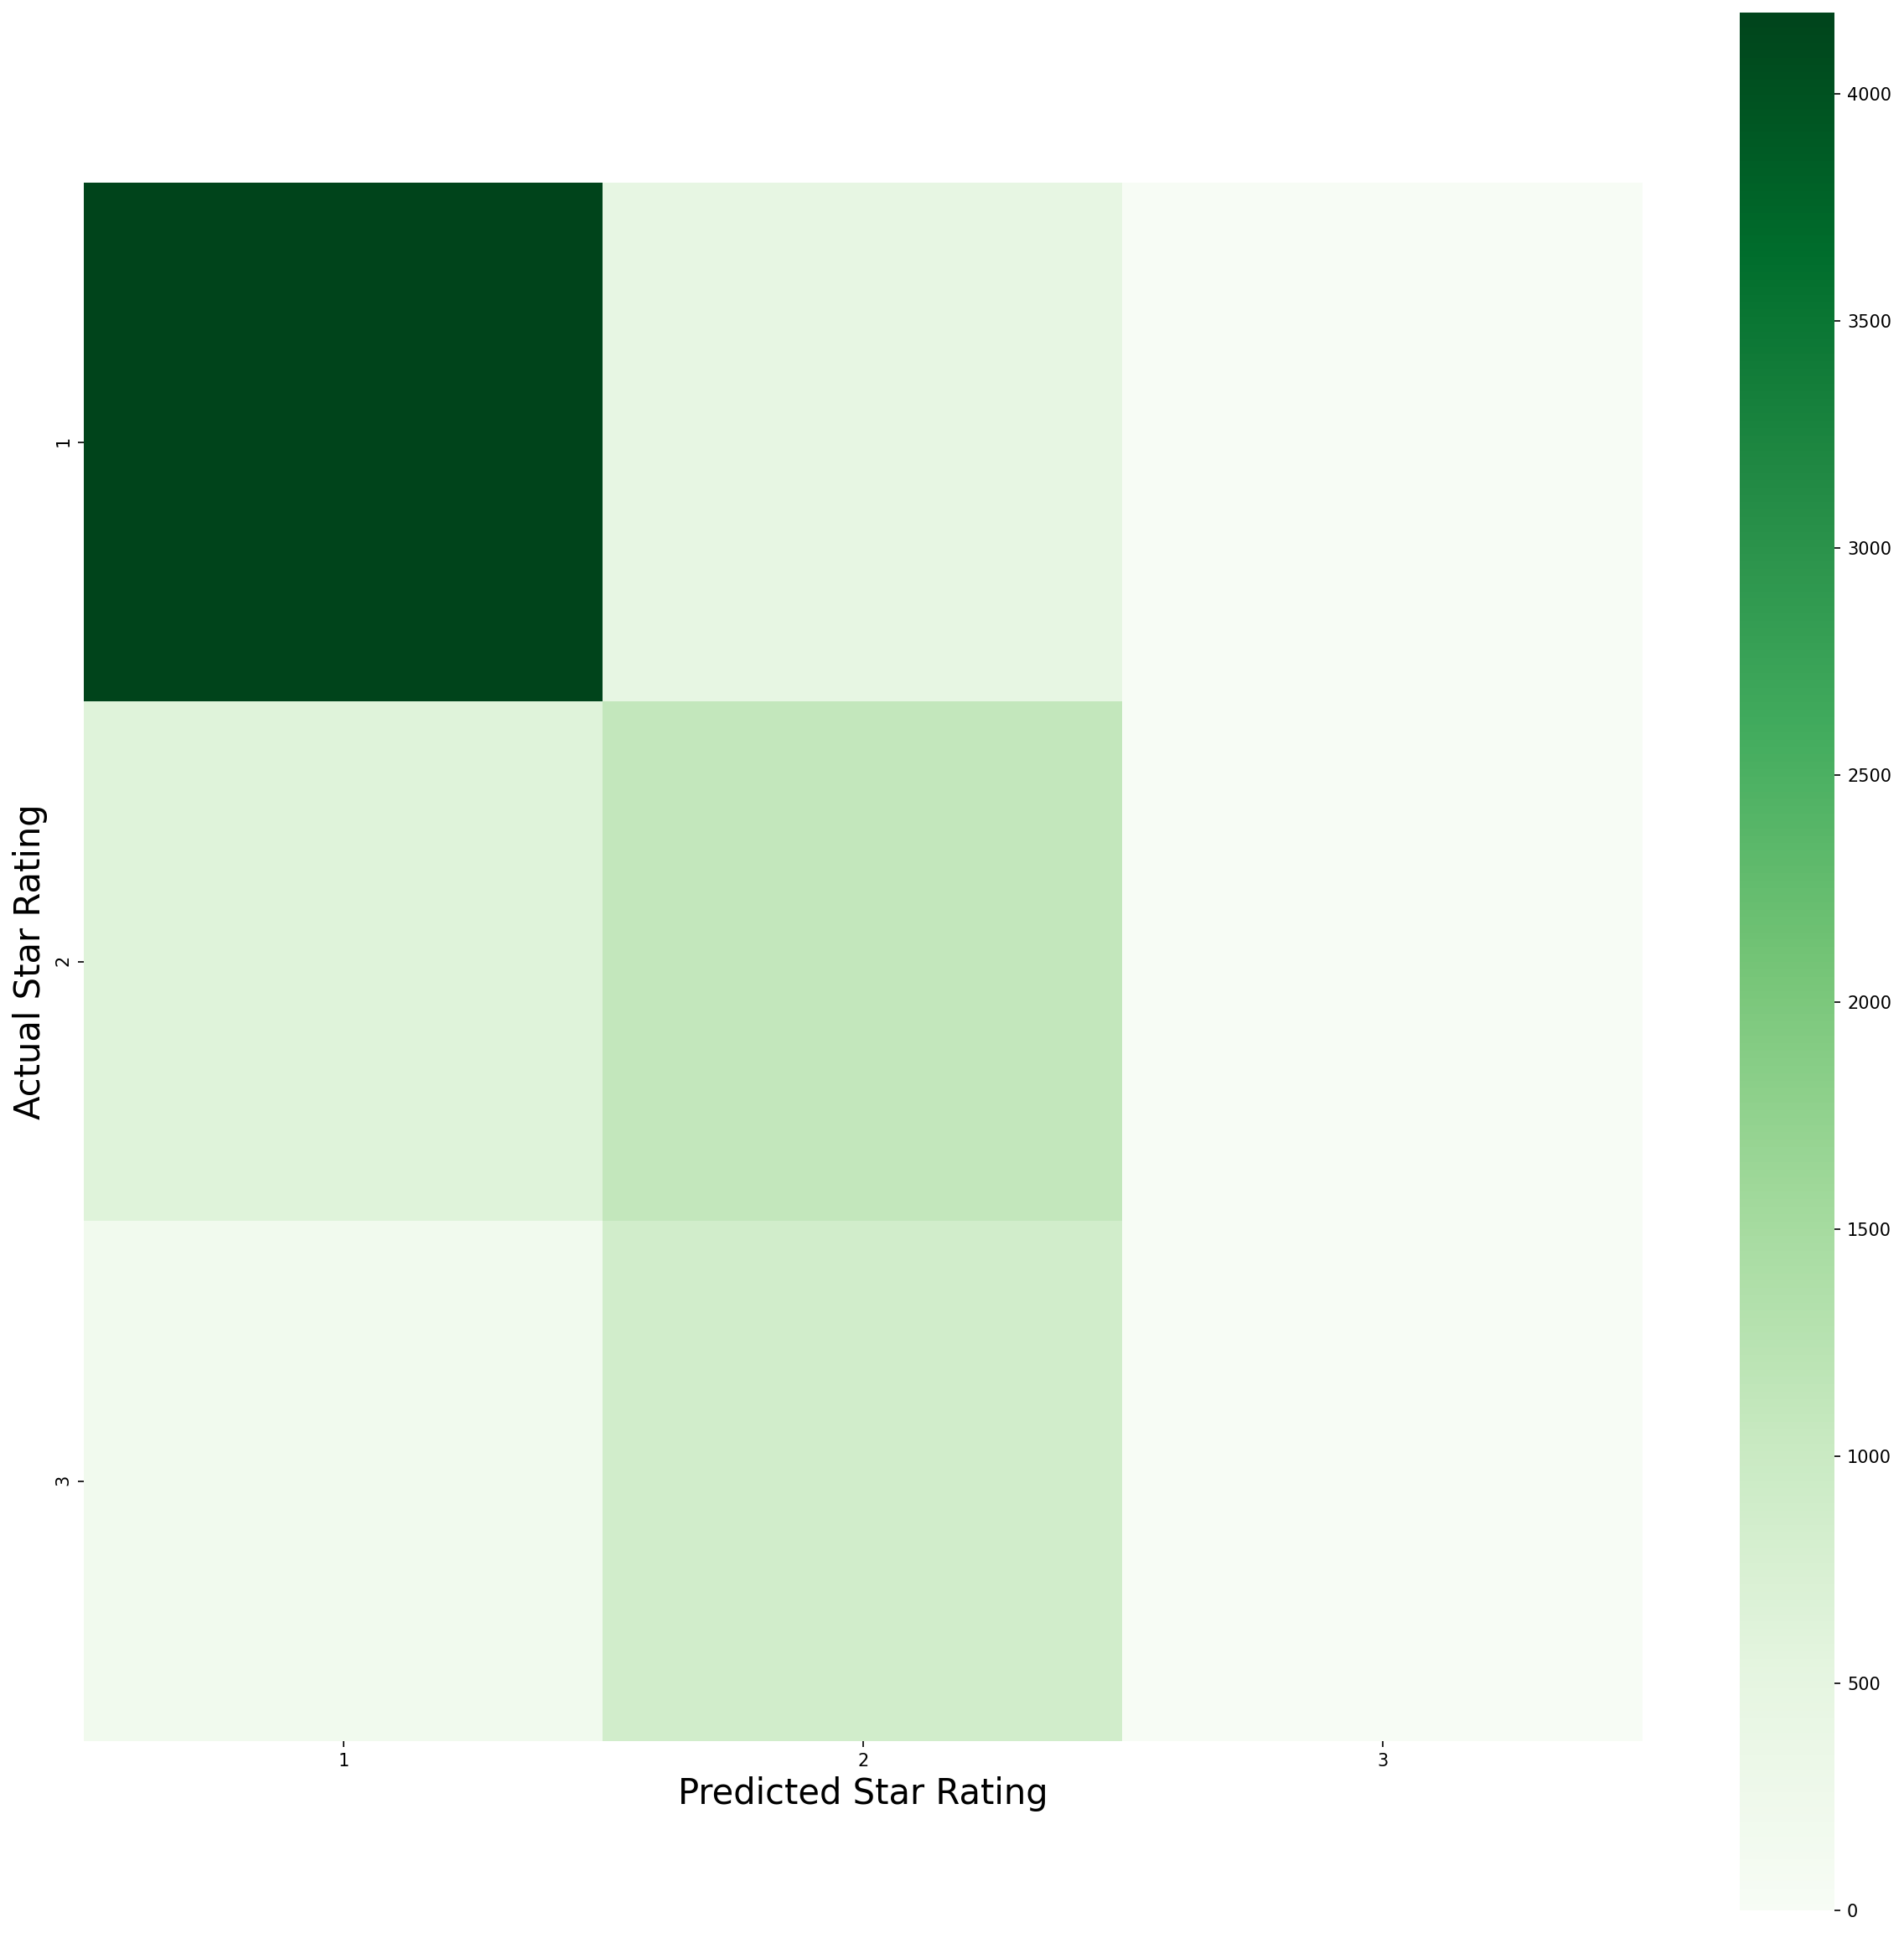

In [115]:
baseline_model_confusion = confusion_matrix(y_test, y_pred_baseline)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(baseline_model_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/baseline_confusion_matrix.png",dpi=400);

Huge overfit!

Things I need to try:

* Collect more data
* Use a pretrained word embedding
* Regularize
* Add callbacks to make training work harder for me
* which should I use as a loss function: `sparse_categorical_crossentropy` or `categorical_crossentropy`
* Which optimizer should I use: `adam` or `RMSprop(lr=0.1)`
* maybe lemmatization is limiting the ability of the model to distinguish a 0 rating and a 1 rating. I 1 rating may be called "bad" but a zero rating will be called "worst" If you lemmatize both "worst" and "bad" get converted to "bad"

**TODO**:
Find out what it means when val_loss improves by val_acc does not improve.

**ANSWER**
Loss can improve if the proba outputs improve yet do not result in a change in prediction -- hence the loss can improve but if the proba don't flip the decision to the right prediction then accuracy will not improve.

**ANSWER**
You should use `sparse_categorical_crossentropy`


## Test Example

In [116]:
score, acc = baseline_model.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

78/78 [==============================] - 16s 210ms/step - loss: 0.6219 - acc: 0.7106


In [117]:
print(score)

0.6219489574432373


In [118]:
print(acc)

0.7105758786201477


In [119]:
#Saving model
baseline_model.save("../Data/baseline_model_arch_weights.h5")

# Updated Model
Will have a model with the following features:

* Pretrained word embedding
* LSTM (or GRU)
* Possibliy bidirectional
* More regularization
* If training is too long: Opt for GRU. Also may opt for a CNN+RNN hybrid


### Pretrained Word Embedding

In [120]:
!./get_word_vectors.sh


File is already downloaded
Done.
Thank you.
Bye.


In [121]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("vocab_size is {}".format(vocab_size))

vocab_size is 30126


In [122]:
#build embedding matrix




embedding_dict = {}

GLOVE6B300_FILE = open("../Data/glove.6B.100d.txt","r")

for line in GLOVE6B300_FILE:
    line_values = line.split(" ")
    word = line_values[0]
    vector_components = np.asarray(line_values[1:], dtype="float32")
    embedding_dict[word] = vector_components

Embedding_Matrix = np.zeros((vocab_size, GLOVE_EMBEDDING_DIM))

for word, index_value in word_index.items():
    embedding_vector = embedding_dict.get(word)
    
    if embedding_vector is not None:
        Embedding_Matrix[index_value] = embedding_vector



In [123]:
Embedding_Matrix.shape

(30126, 100)

### Multi Level (DEEP) LSTM Model

Warning: This model takes 1 hour / epic to train and the early `val_acc` is 0.15. You can skip to the next model.

In [124]:
tensorflow.keras.backend.clear_session()


In [125]:
updated_model = Sequential()
updated_model.add(Embedding(vocab_size, GLOVE_EMBEDDING_DIM, input_length=Max_Length, weights=[Embedding_Matrix], trainable=False))
updated_model.add(Bidirectional(LSTM(32, return_sequences=True)))
updated_model.add(Bidirectional(LSTM(32, return_sequences=True)))
updated_model.add(Bidirectional(LSTM(32)))
updated_model.add(Dense(32, activation="relu"))
updated_model.add(Dense(10, activation="softmax"))

my_adam_optimizer = Adam(lr=0.01)
updated_model.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
updated_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7779, 100)         3012600   
_________________________________________________________________
bidirectional (Bidirectional (None, 7779, 64)          34048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7779, 64)          24832     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 3,098,722
Trainable params: 86,122
Non-trainable params: 3,012,600
_________________________________________

In [126]:
call_back_list2 = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/updated_model.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 3
    ),
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [127]:
training_history2 = updated_model.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list2,
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/100
628/628 [==============================] - 713s 1s/step - loss: 0.7474 - acc: 0.6757 - val_loss: 0.6403 - val_acc: 0.7086 - lr: 0.0100
Epoch 2/100
628/628 [==============================] - 706s 1s/step - loss: 0.6138 - acc: 0.7238 - val_loss: 0.6007 - val_acc: 0.7300 - lr: 0.0100
Epoch 3/100
628/628 [==============================] - 708s 1s/step - loss: 0.5969 - acc: 0.7274 - val_loss: 0.6061 - val_acc: 0.7272 - lr: 0.0100
Epoch 4/100
628/628 [==============================] - 709s 1s/step - loss: 0.5829 - acc: 0.7339 - val_loss: 0.6223 - val_acc: 0.7164 - lr: 0.0100
Epoch 5/100
628/628 [==============================] - 704s 1s/step - loss: 0.5647 - acc: 0.7433 - val_loss: 0.5938 - val_acc: 0.7343 - lr: 0.0100
Epoch 6/100
628/628 [==============================] - 704s 1s/step - loss: 0.5534 - acc: 0.7500 - val_loss: 0.5812 - val_acc: 0.7352 - lr: 0.0100
Epoch 7/100
628/628 [==============================] - 704s 1s/step - loss: 0.5384 - acc: 0.7567 - val_loss: 0.5778 - 

Just _one_ epic takes over an hour. Will try a smaller model.

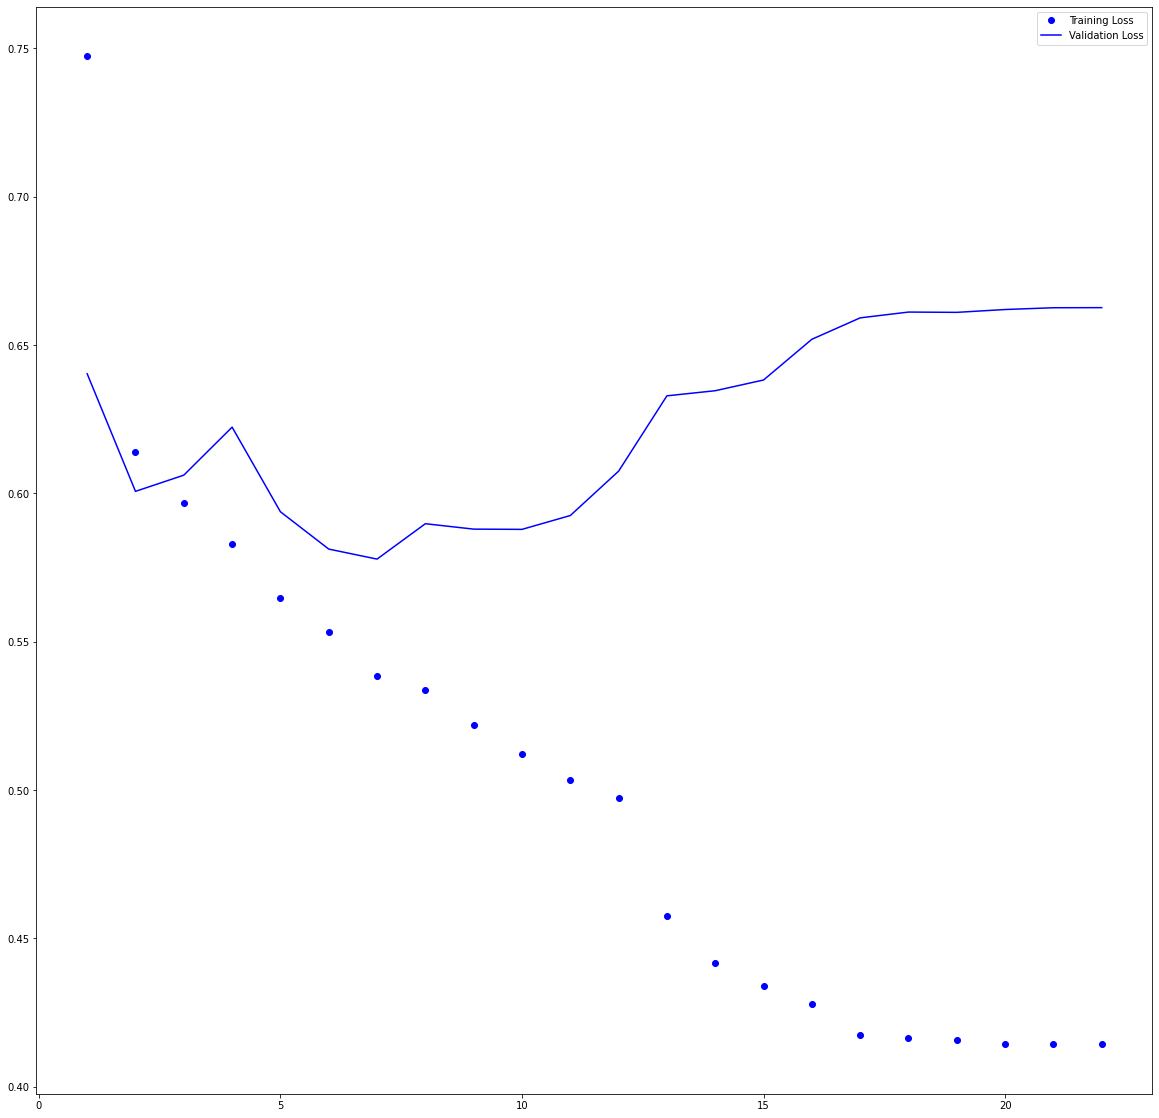

<Figure size 432x288 with 0 Axes>

In [128]:
loss = training_history2.history["loss"]
val_loss = training_history2.history["val_loss"]
acc = training_history2.history["acc"]
val_acc = training_history2.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
plt.show()
plt.savefig("../Documents/Images/loss_curves2.png",dpi=400)

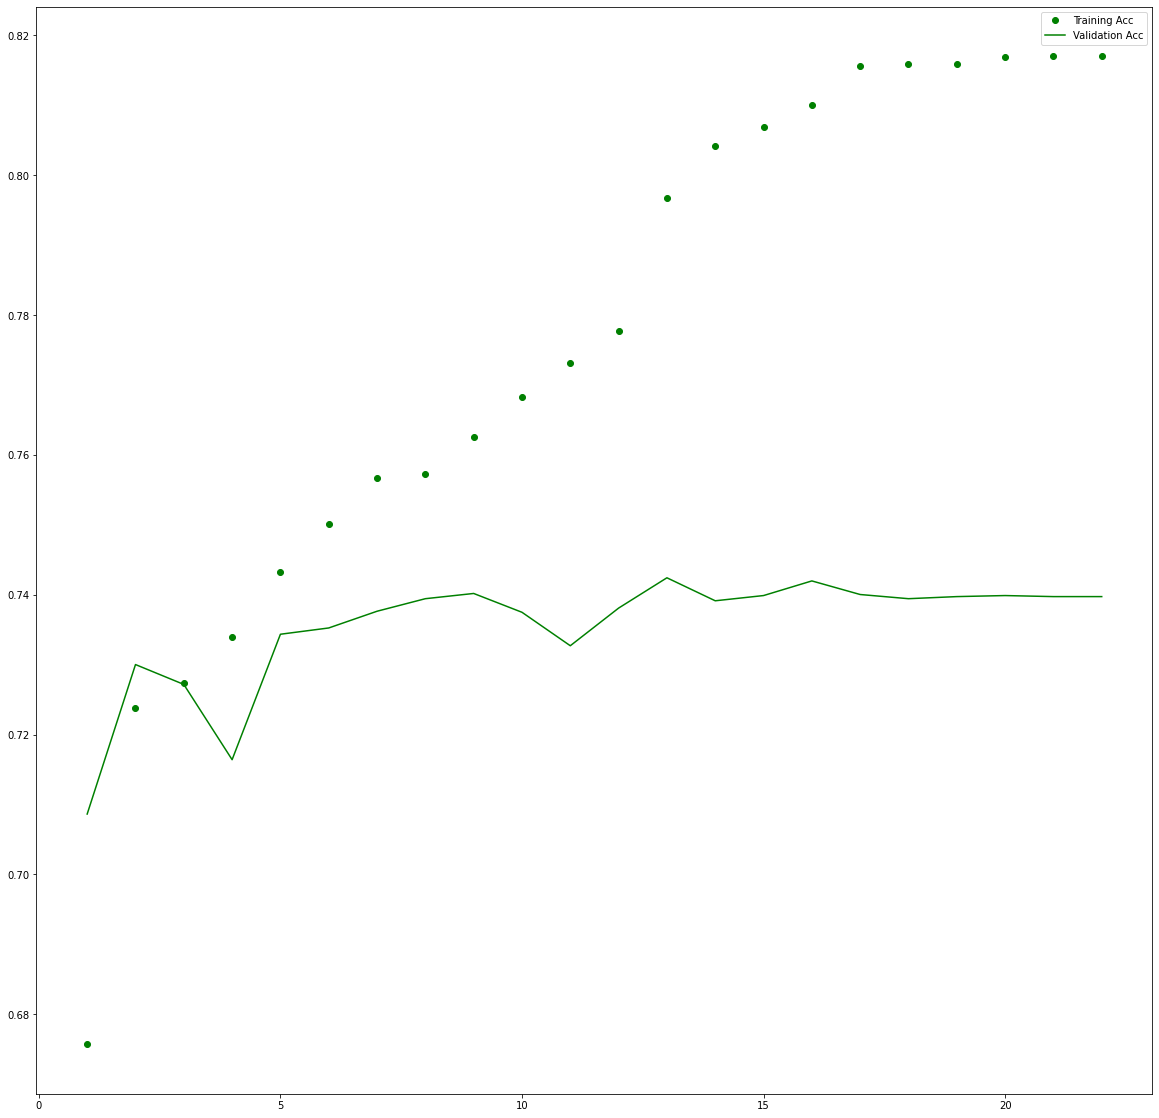

<Figure size 432x288 with 0 Axes>

In [129]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
plt.show()
plt.savefig("../Documents/Images/accuracy_curves2.png",dpi=400)

In [130]:
y_pred_baseline = updated_model.predict(X_test_seq_pad)
y_pred_baseline = [np.argmax(y_thing) for y_thing in y_pred_baseline]

In [131]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_baseline, target_names=target_names))

              precision    recall  f1-score   support

           1       0.86      0.88      0.87      4651
           2       0.50      0.62      0.55      1736
           3       0.66      0.33      0.44      1045

    accuracy                           0.74      7432
   macro avg       0.67      0.61      0.62      7432
weighted avg       0.75      0.74      0.74      7432



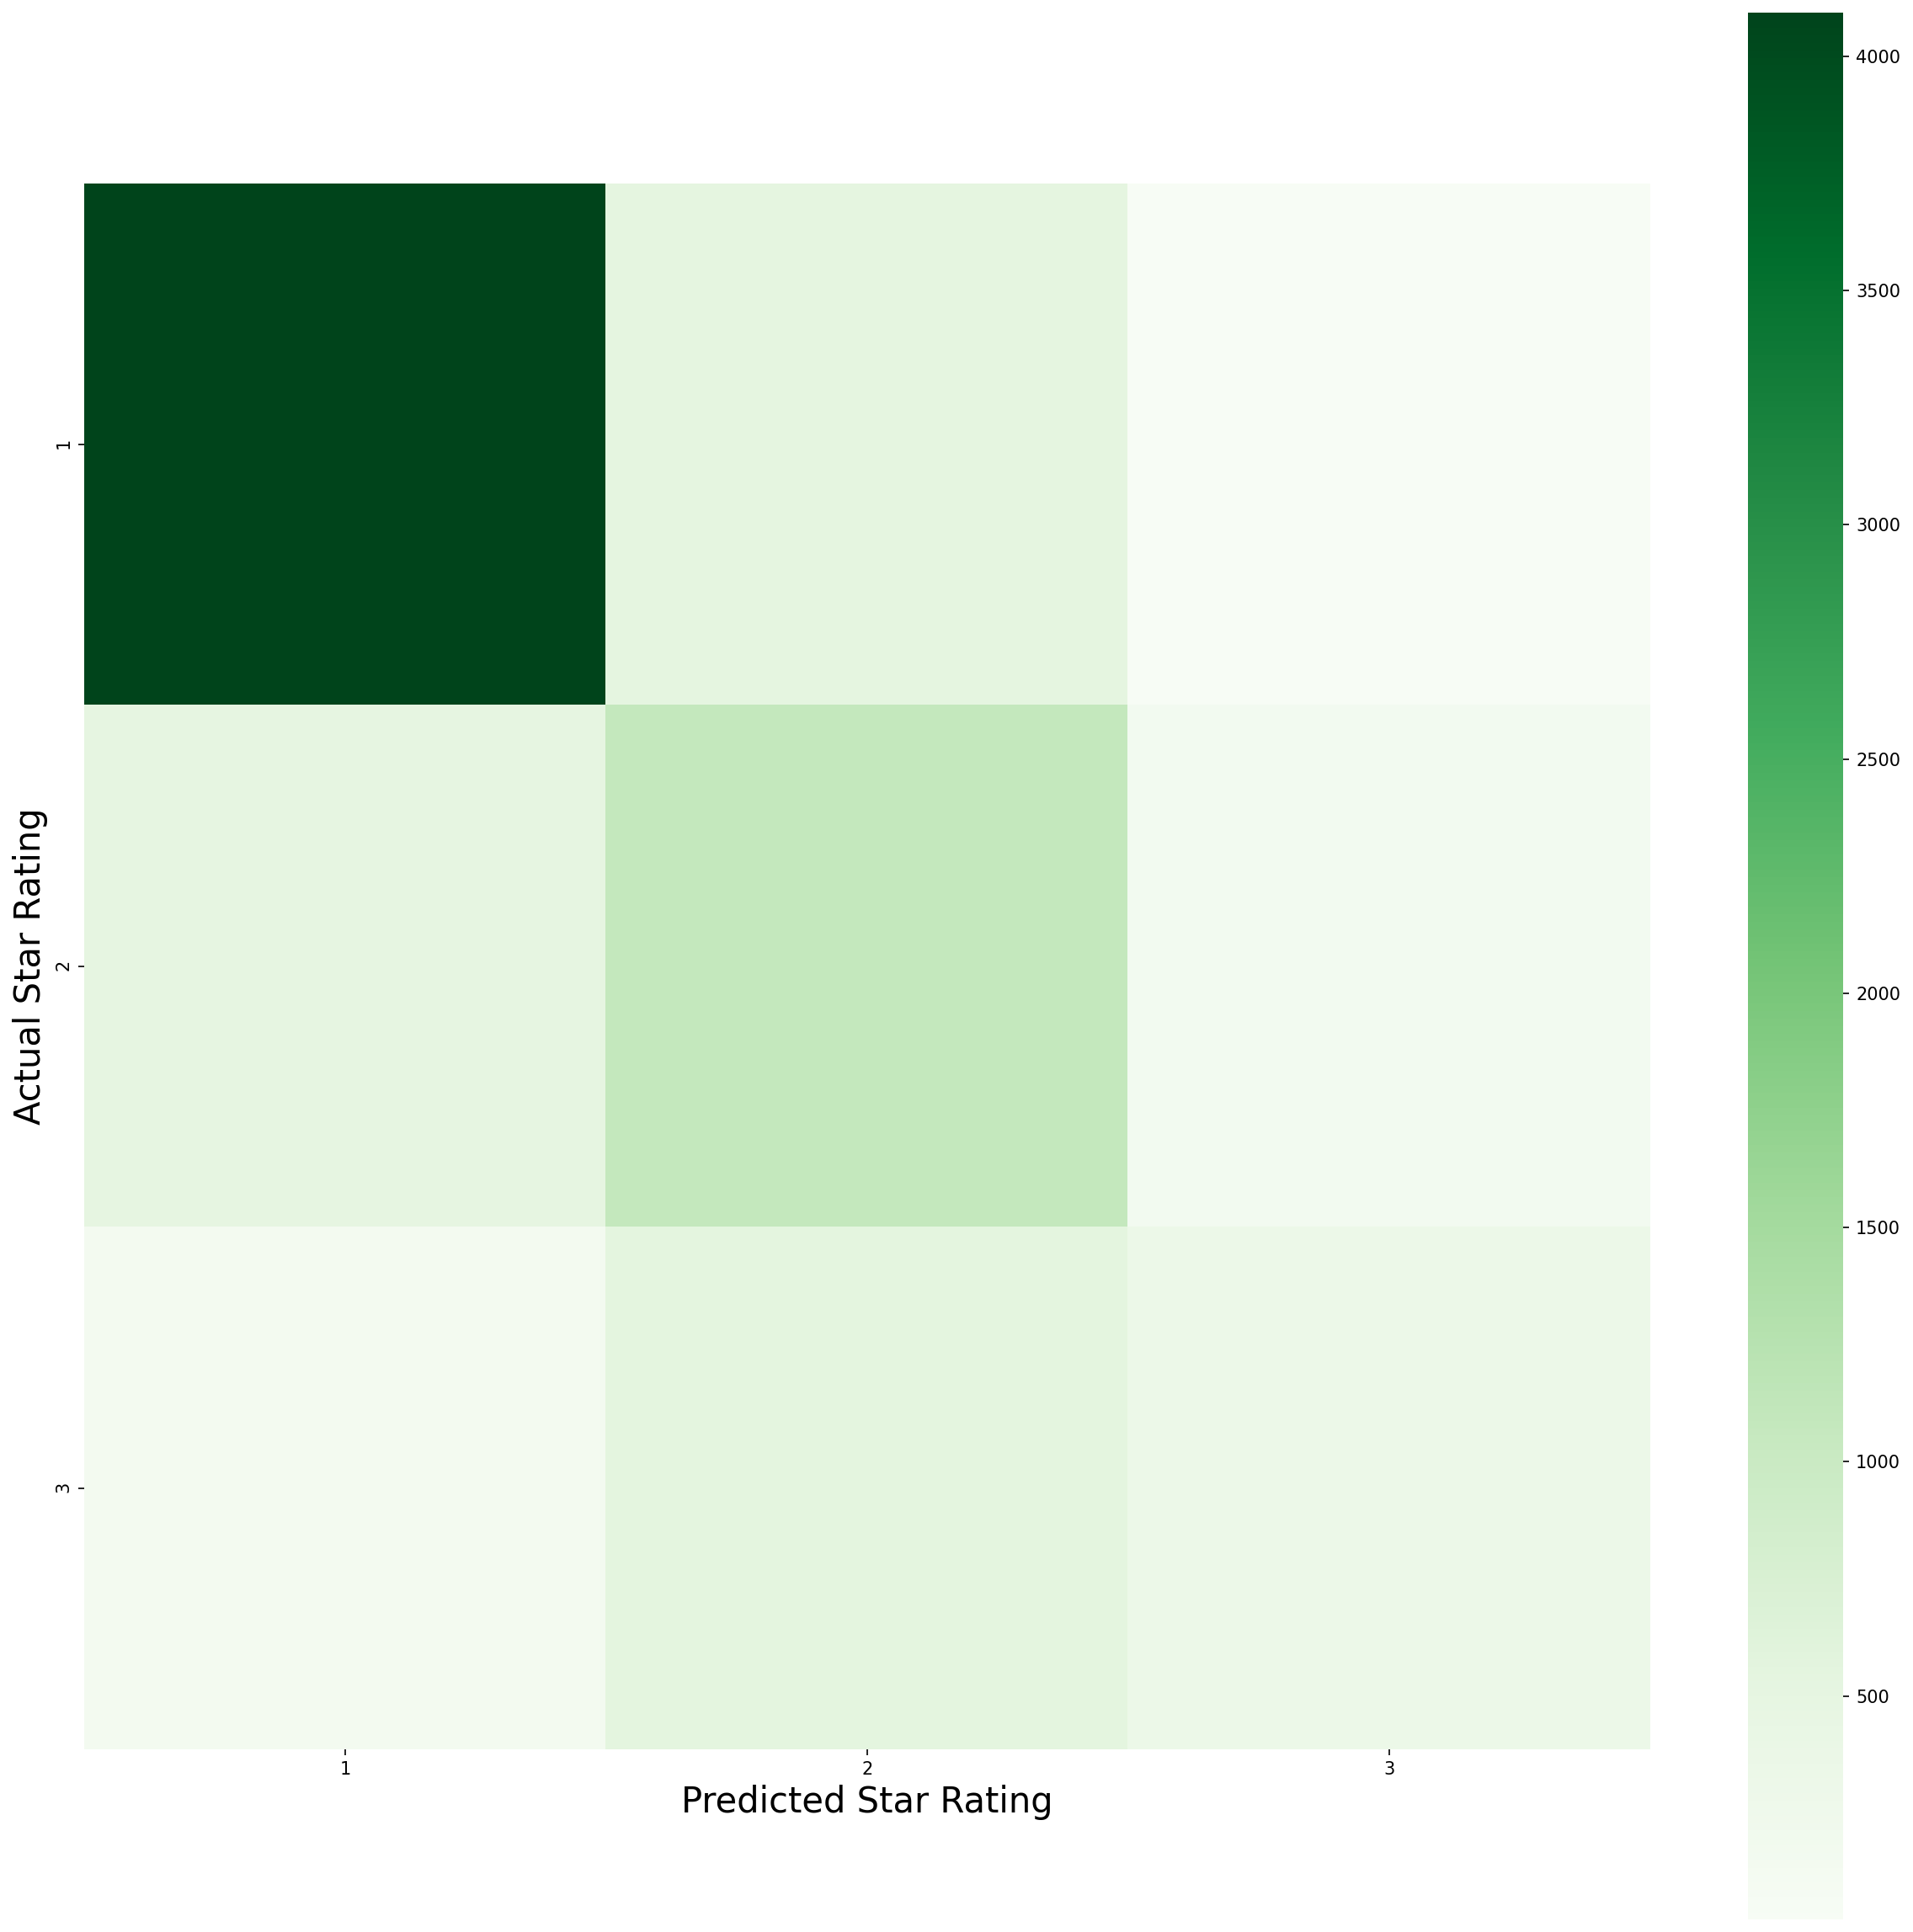

In [132]:
updated_model_confusion = confusion_matrix(y_test, y_pred_baseline)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(updated_model_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/updated_confusion_matrix.png",dpi=400);

In [133]:
score, acc = updated_model.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

78/78 [==============================] - 43s 554ms/step - loss: 0.5792 - acc: 0.7418


In [134]:
print(score)

0.579230010509491


In [135]:
print(acc)

0.7417922616004944


In [136]:
#Saving model
updated_model.save("../Data/updated_model_arch_weights.h5")

###  Less Complex LSTM Model

In [137]:
tensorflow.keras.backend.clear_session()


In [138]:
updated_model2 = Sequential()
updated_model2.add(Embedding(vocab_size, GLOVE_EMBEDDING_DIM, input_length=Max_Length, weights=[Embedding_Matrix], trainable=False))
updated_model2.add( Bidirectional( LSTM(128)) )
#updated_model2.add(Dense(128, activation="relu"))
#updated_model2.add(Dropout(0.2))
#updated_model2.add(Dense(64, activation="relu"))
#updated_model2.add(Dropout(0.2))
updated_model2.add(Dense(32, activation="relu"))
updated_model2.add(Dropout(0.2))
updated_model2.add(Dense(16, activation="relu"))
updated_model2.add(Dropout(0.2))
updated_model2.add(Dense(3, activation="softmax"))


my_adam_optimizer = Adam(lr=0.001)

updated_model2.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
updated_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7779, 100)         3012600   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 5

In [139]:
call_back_list3 = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/updated_model2.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 3
    ),
    #patience==6 in the original model
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [140]:
training_history3 = updated_model2.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list3,
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/100
628/628 [==============================] - 407s 648ms/step - loss: 0.7861 - acc: 0.6565 - val_loss: 0.8436 - val_acc: 0.5766 - lr: 0.0010
Epoch 2/100
628/628 [==============================] - 408s 650ms/step - loss: 0.6658 - acc: 0.6968 - val_loss: 0.6276 - val_acc: 0.7170 - lr: 0.0010
Epoch 3/100
628/628 [==============================] - 407s 649ms/step - loss: 0.6163 - acc: 0.7246 - val_loss: 0.5962 - val_acc: 0.7272 - lr: 0.0010
Epoch 4/100
628/628 [==============================] - 409s 651ms/step - loss: 0.5868 - acc: 0.7385 - val_loss: 0.6033 - val_acc: 0.7219 - lr: 0.0010
Epoch 5/100
628/628 [==============================] - 408s 649ms/step - loss: 0.5679 - acc: 0.7472 - val_loss: 0.5649 - val_acc: 0.7475 - lr: 0.0010
Epoch 6/100
628/628 [==============================] - 405s 645ms/step - loss: 0.5518 - acc: 0.7520 - val_loss: 0.5604 - val_acc: 0.7462 - lr: 0.0010
Epoch 7/100
628/628 [==============================] - 405s 644ms/step - loss: 0.5321 - acc: 0.7616 

In [141]:
score, acc = updated_model2.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

78/78 [==============================] - 20s 263ms/step - loss: 0.5503 - acc: 0.7503


In [142]:
print(score)

0.5503480434417725


In [143]:
print(acc)

0.7502691149711609


In [144]:
y_pred_updated_model2 = updated_model2.predict(X_test_seq_pad)
y_pred_updated_model2 = [np.argmax(y_thing) for y_thing in y_pred_updated_model2]


In [145]:
#target_names = list(range(10))
#target_names = [str(thing) for thing in target_names]


In [146]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_updated_model2, target_names=target_names))

              precision    recall  f1-score   support

           1       0.88      0.88      0.88      4651
           2       0.51      0.59      0.55      1736
           3       0.59      0.44      0.51      1045

    accuracy                           0.75      7432
   macro avg       0.66      0.64      0.64      7432
weighted avg       0.75      0.75      0.75      7432



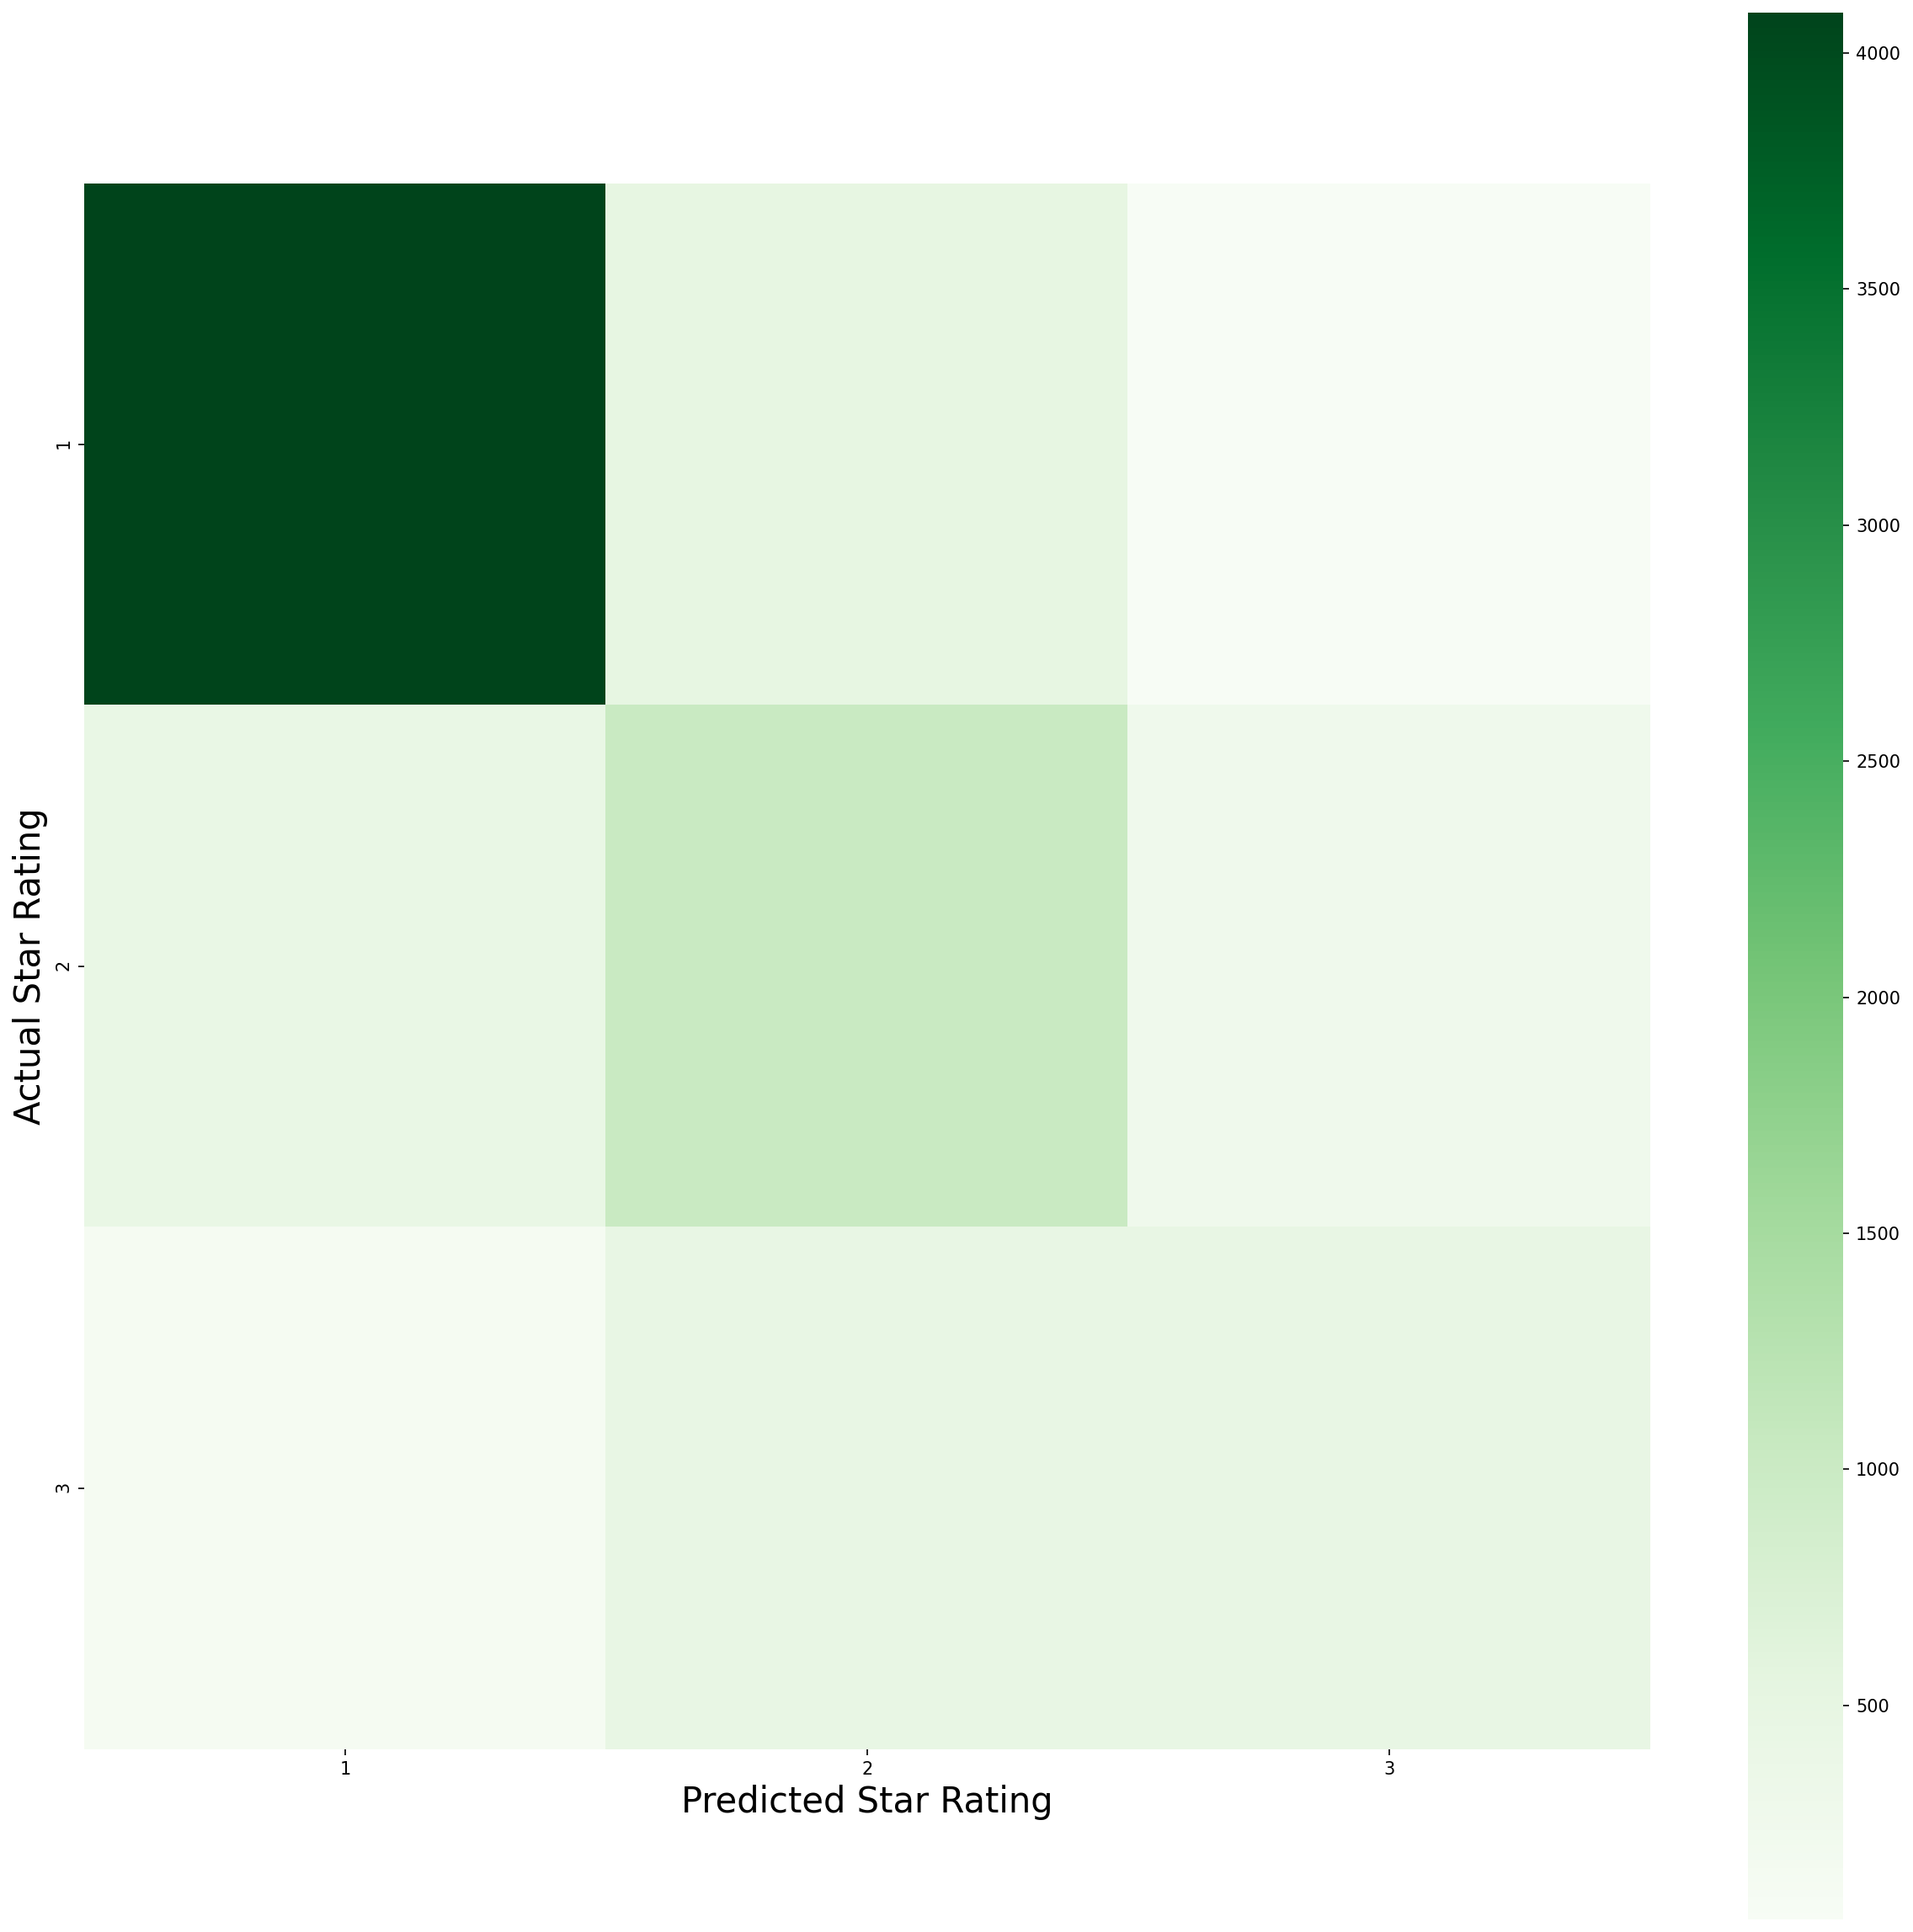

In [147]:
updated_model2_confusion = confusion_matrix(y_test, y_pred_updated_model2)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(updated_model2_confusion, cmap=plt.cm.Greens, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating",fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/updated_model2_confusion_matrix.png",dpi=400);

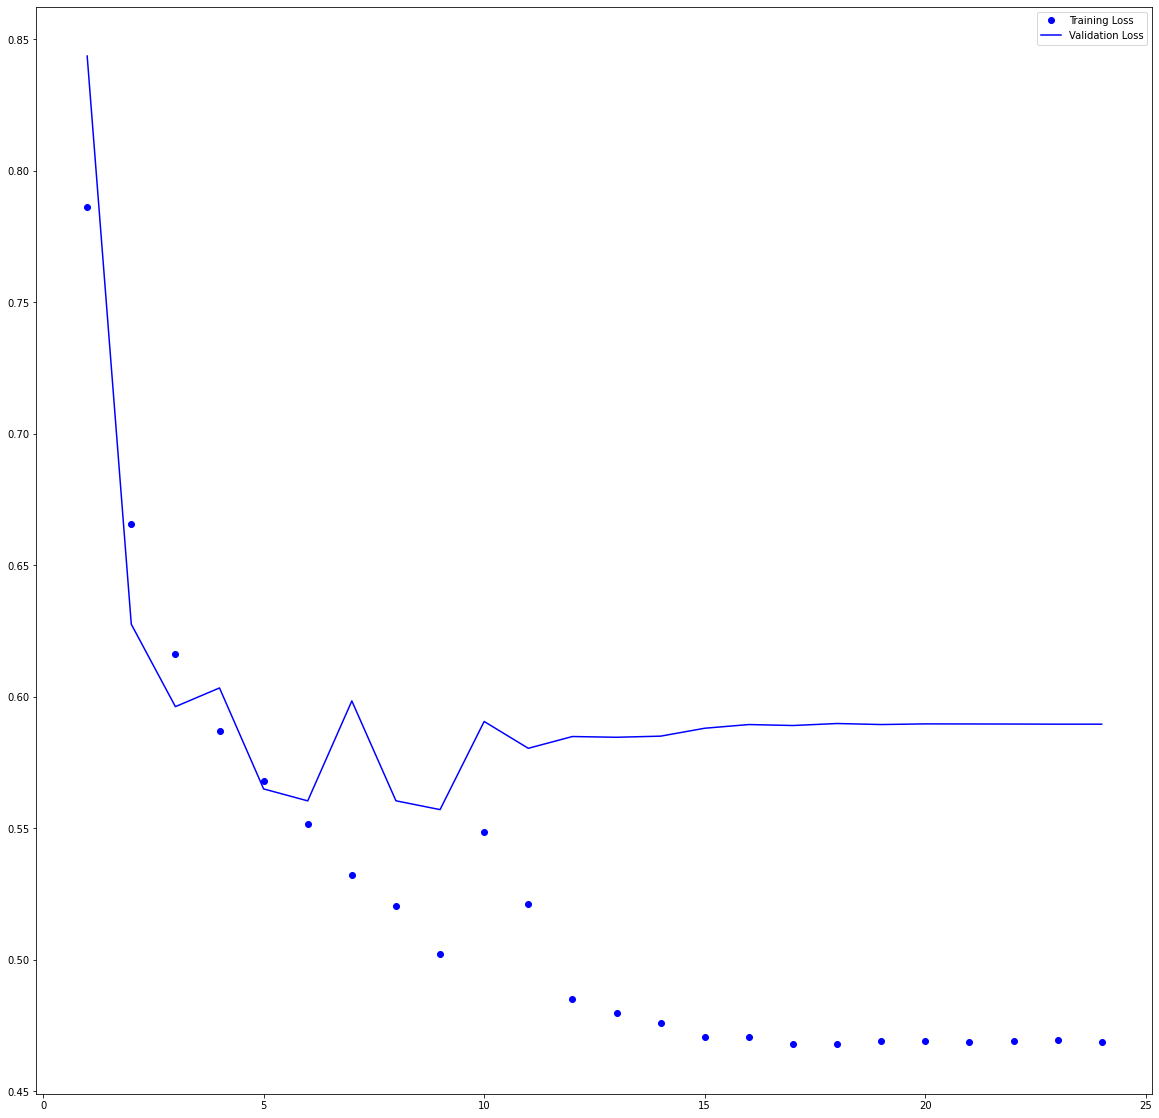

In [148]:
loss = training_history3.history["loss"]
val_loss = training_history3.history["val_loss"]
acc = training_history3.history["acc"]
val_acc = training_history3.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/loss_curves_update_model2.png",dpi=400)

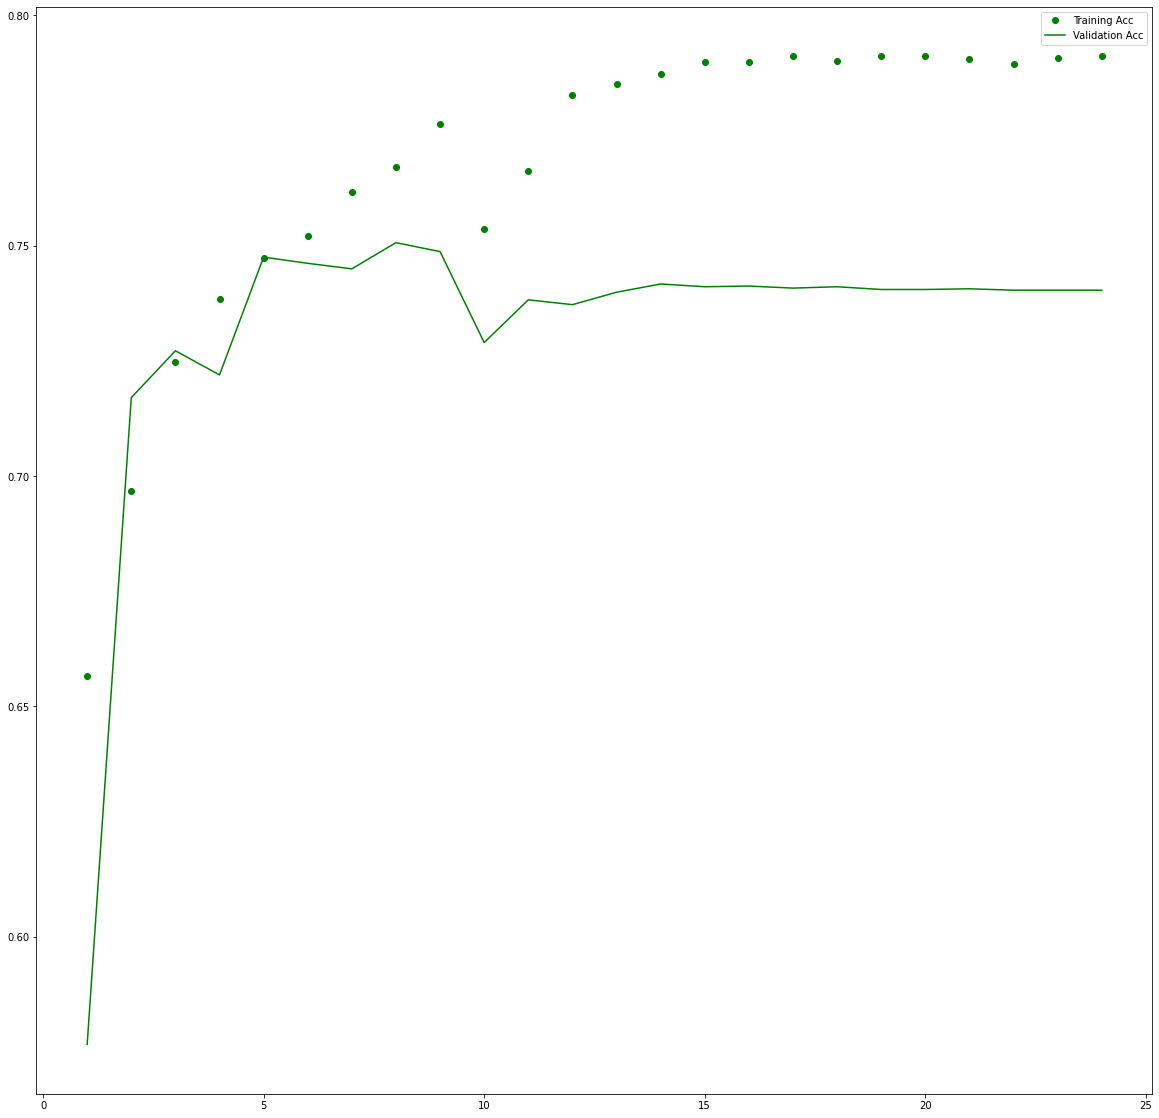

In [149]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/accuracy_curves_update_model2.png",dpi=400)

In [150]:
#Saving model
updated_model2.save("../Data/updated_model2_arch_weights.h5")

### More Complex CNN

In [151]:
tensorflow.keras.backend.clear_session()


In [152]:
baseline_model2 = Sequential()
baseline_model2.add(Embedding(vocab_size, BASELINE_EMBEDDING_DIM, input_length=Max_Length))
#baseline_model2.add(Conv1D(32,7,activation="relu",kernel_regularizer=regularizers.l2(0.001)))
baseline_model2.add(Conv1D(32,9,activation="relu",
           kernel_initializer=keras.initializers.glorot_normal(seed=RANDOM_STATE))
#           kernel_regularizer=regularizers.l2(0.0006))
    )
baseline_model2.add(MaxPooling1D(5))
#baseline_model2.add(Conv1D(32,7,activation="relu",kernel_regularizer=regularizers.l2(0.001)))
baseline_model2.add(
    Conv1D(32,
           9,
           activation="relu",
           kernel_initializer=keras.initializers.glorot_normal(seed=RANDOM_STATE))
#    kernel_regularizer=regularizers.l2(0.0007))
)
baseline_model2.add(MaxPooling1D(5))
baseline_model2.add(Conv1D(
    32,
    9,
    activation="relu",
    kernel_initializer=keras.initializers.glorot_normal(seed=RANDOM_STATE))
    #kernel_regularizer=regularizers.l2(0.0007))
)
#baseline_model2.add(GlobalMaxPooling1D())
baseline_model2.add(Flatten())
#baseline_model2.add(Dense(16, activation="relu", kernel_regularizer=regularizers.l2(0.015)))
baseline_model2.add(Dense(64, activation="relu"))
#baseline_model2.add(Dropout(0.2))
baseline_model2.add(Dense(32, activation="relu"))
#baseline_model2.add(Dropout(0.2))
baseline_model2.add(Dense(16, activation="relu"))
#baseline_model2.add(Dropout(0.2))
#baseline_model2.add(Dense(3, activation="softmax", kernel_regularizer=regularizers.l2(0.0007)))
baseline_model2.add(Dense(3, activation="softmax"))
my_adam_optimizer = Adam(lr=0.01)

baseline_model2.compile(optimizer=my_adam_optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"])
baseline_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7779, 32)          964032    
_________________________________________________________________
conv1d (Conv1D)              (None, 7771, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1554, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1546, 32)          9248      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 309, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 301, 32)           9248      
_________________________________________________________________
flatten (Flatten)            (None, 9632)              0

In [153]:
call_back_list4 = [
    keras.callbacks.ModelCheckpoint(
        filepath = "../Data/baseline_model2.h5",
        monitor = "val_acc",
        save_best_only = True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor = "val_acc",
        factor = 0.1,
        patience = 5
    ),
    keras.callbacks.EarlyStopping(patience=15, verbose=1,restore_best_weights=True)
    
    
]

In [154]:
training_history4 = baseline_model2.fit(X_train_seq_pad,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      callbacks=call_back_list4,
                                      validation_split=Test_Size, 
                                      verbose=1)

Epoch 1/100
628/628 [==============================] - 120s 190ms/step - loss: 0.6839 - acc: 0.6895 - val_loss: 0.6962 - val_acc: 0.6790 - lr: 0.0100
Epoch 2/100
628/628 [==============================] - 40s 63ms/step - loss: 0.5605 - acc: 0.7438 - val_loss: 0.6141 - val_acc: 0.7290 - lr: 0.0100
Epoch 3/100
628/628 [==============================] - 39s 62ms/step - loss: 0.5011 - acc: 0.7743 - val_loss: 0.6408 - val_acc: 0.7050 - lr: 0.0100
Epoch 4/100
628/628 [==============================] - 39s 62ms/step - loss: 0.4501 - acc: 0.8001 - val_loss: 0.7296 - val_acc: 0.7264 - lr: 0.0100
Epoch 5/100
628/628 [==============================] - 39s 62ms/step - loss: 0.3985 - acc: 0.8255 - val_loss: 0.6816 - val_acc: 0.7128 - lr: 0.0100
Epoch 6/100
628/628 [==============================] - 39s 62ms/step - loss: 0.3511 - acc: 0.8524 - val_loss: 0.8128 - val_acc: 0.7140 - lr: 0.0100
Epoch 7/100
628/628 [==============================] - 39s 62ms/step - loss: 0.3158 - acc: 0.8727 - val_loss: 

In [155]:
score, acc = baseline_model2.evaluate(X_test_seq_pad, y_test, batch_size=BATCH_SIZE)

78/78 [==============================] - 30s 386ms/step - loss: 0.6136 - acc: 0.7274


In [156]:
print(score)

0.6135900616645813


In [157]:
print(acc)

0.7273950576782227


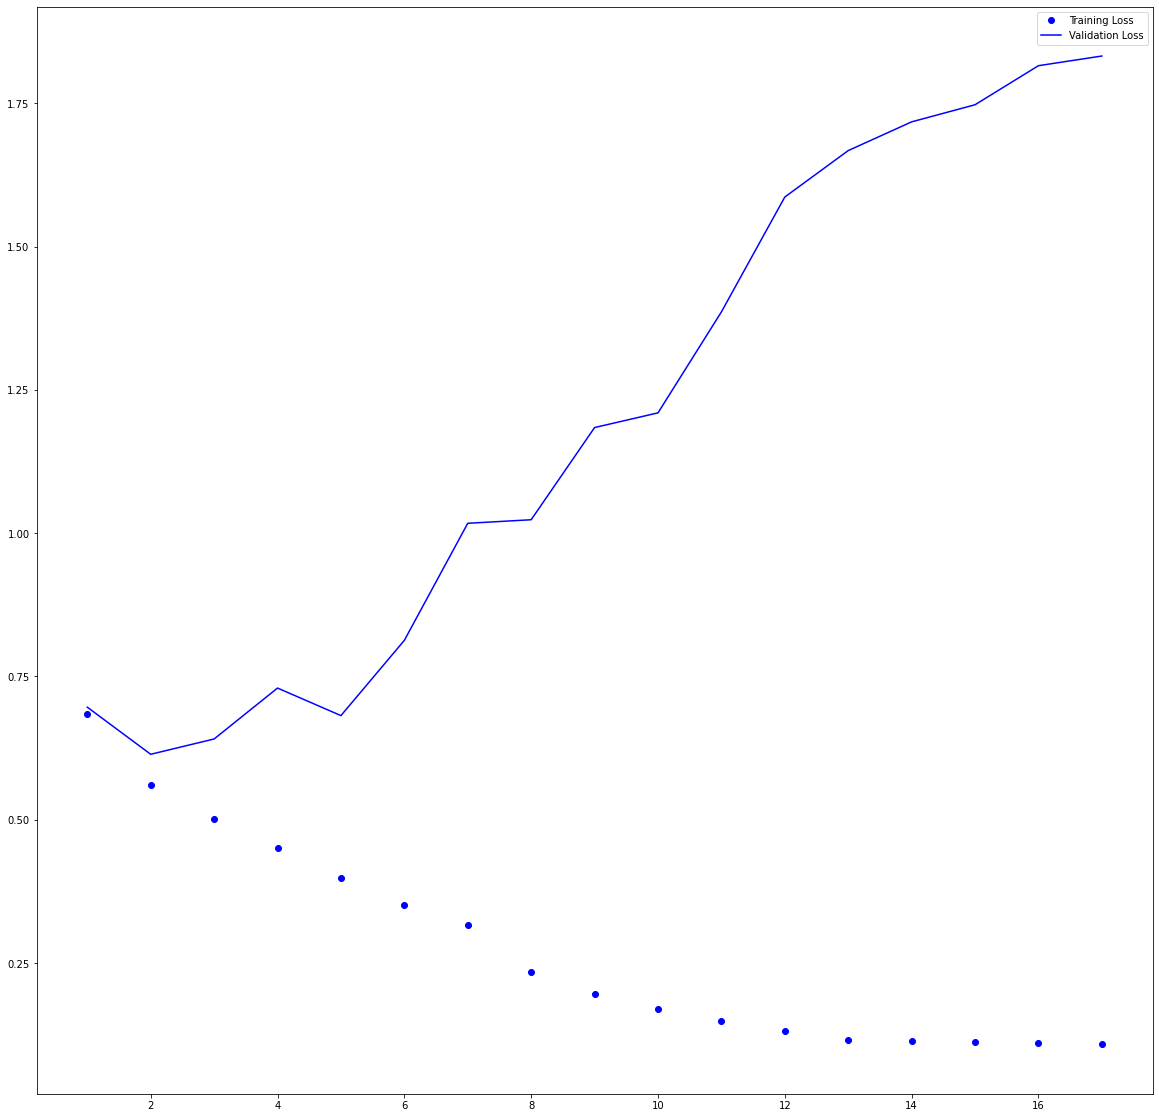

In [158]:
loss = training_history4.history["loss"]
val_loss = training_history4.history["val_loss"]
acc = training_history4.history["acc"]
val_acc = training_history4.history["val_acc"]
epochs = range(1,len(loss)+1)

plt.figure(figsize=(20,20))
plt.plot(epochs, loss,"bo",label="Training Loss")
plt.plot(epochs, val_loss,"b",label="Validation Loss")

plt.legend()
#plt.show()
plt.savefig("../Documents/Images/baseline_model2_loss_curves.png",dpi=400)


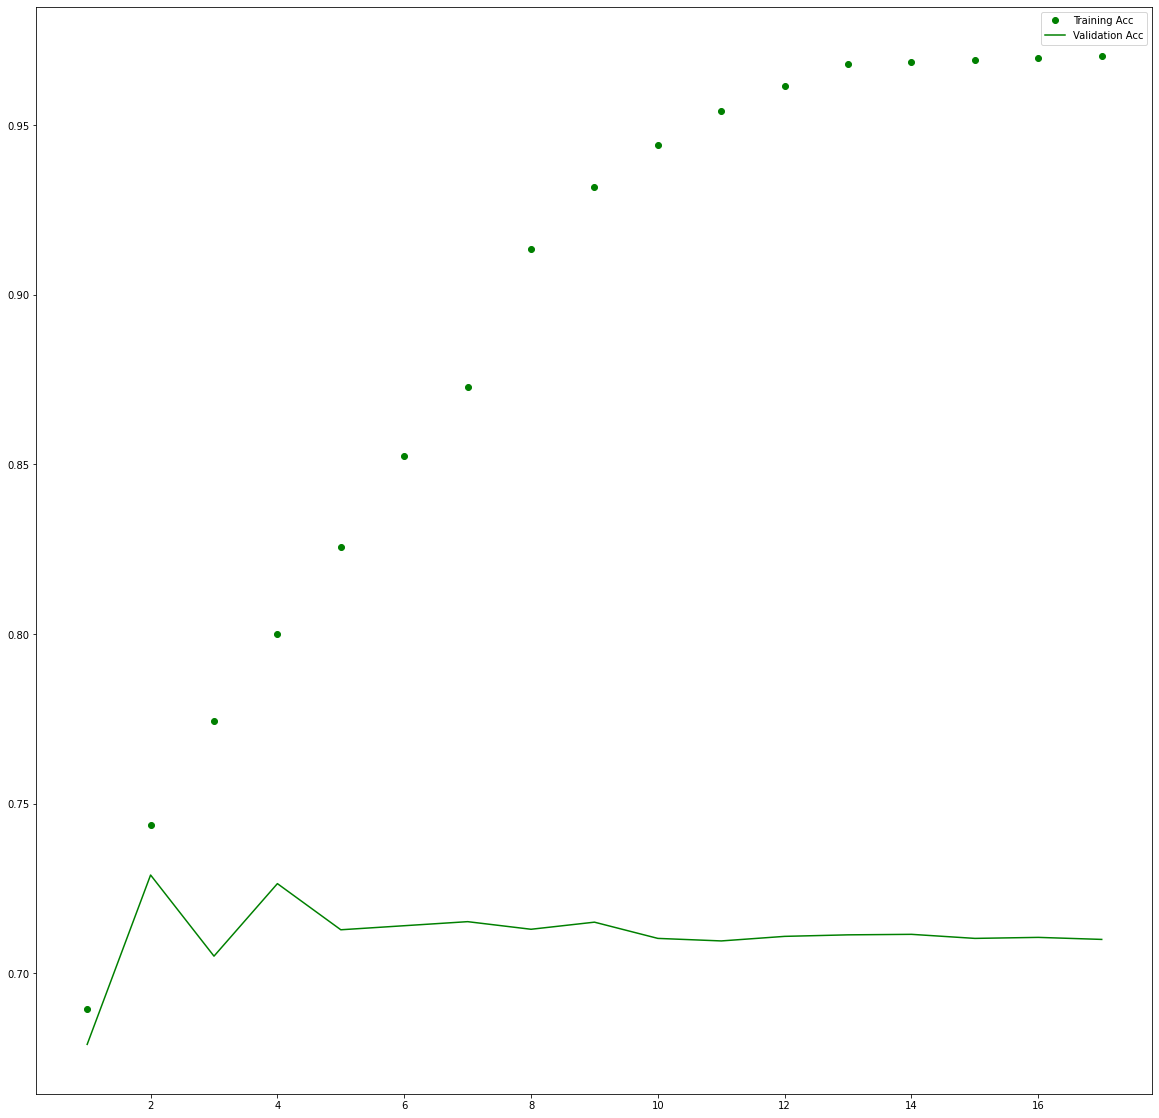

In [159]:
plt.figure(figsize=(20,20))
plt.plot(epochs, acc,"go",label="Training Acc")
plt.plot(epochs, val_acc,"g",label="Validation Acc")
plt.legend()
#plt.show()
plt.savefig("../Documents/Images/baseline_model2_accuracy_curves.png",dpi=400)

In [160]:
y_pred_baseline2 = baseline_model2.predict(X_test_seq_pad)
y_pred_baseline2 = [np.argmax(y_thing) for y_thing in y_pred_baseline2]


In [161]:
#target_names = list(range(10))
#target_names = [str(thing+1) for thing in target_names]


In [162]:
#target_names is expected to be a string
print(classification_report(y_test, y_pred_baseline2, target_names=target_names))

              precision    recall  f1-score   support

           1       0.88      0.85      0.87      4651
           2       0.47      0.57      0.51      1736
           3       0.56      0.43      0.49      1045

    accuracy                           0.73      7432
   macro avg       0.64      0.62      0.62      7432
weighted avg       0.74      0.73      0.73      7432



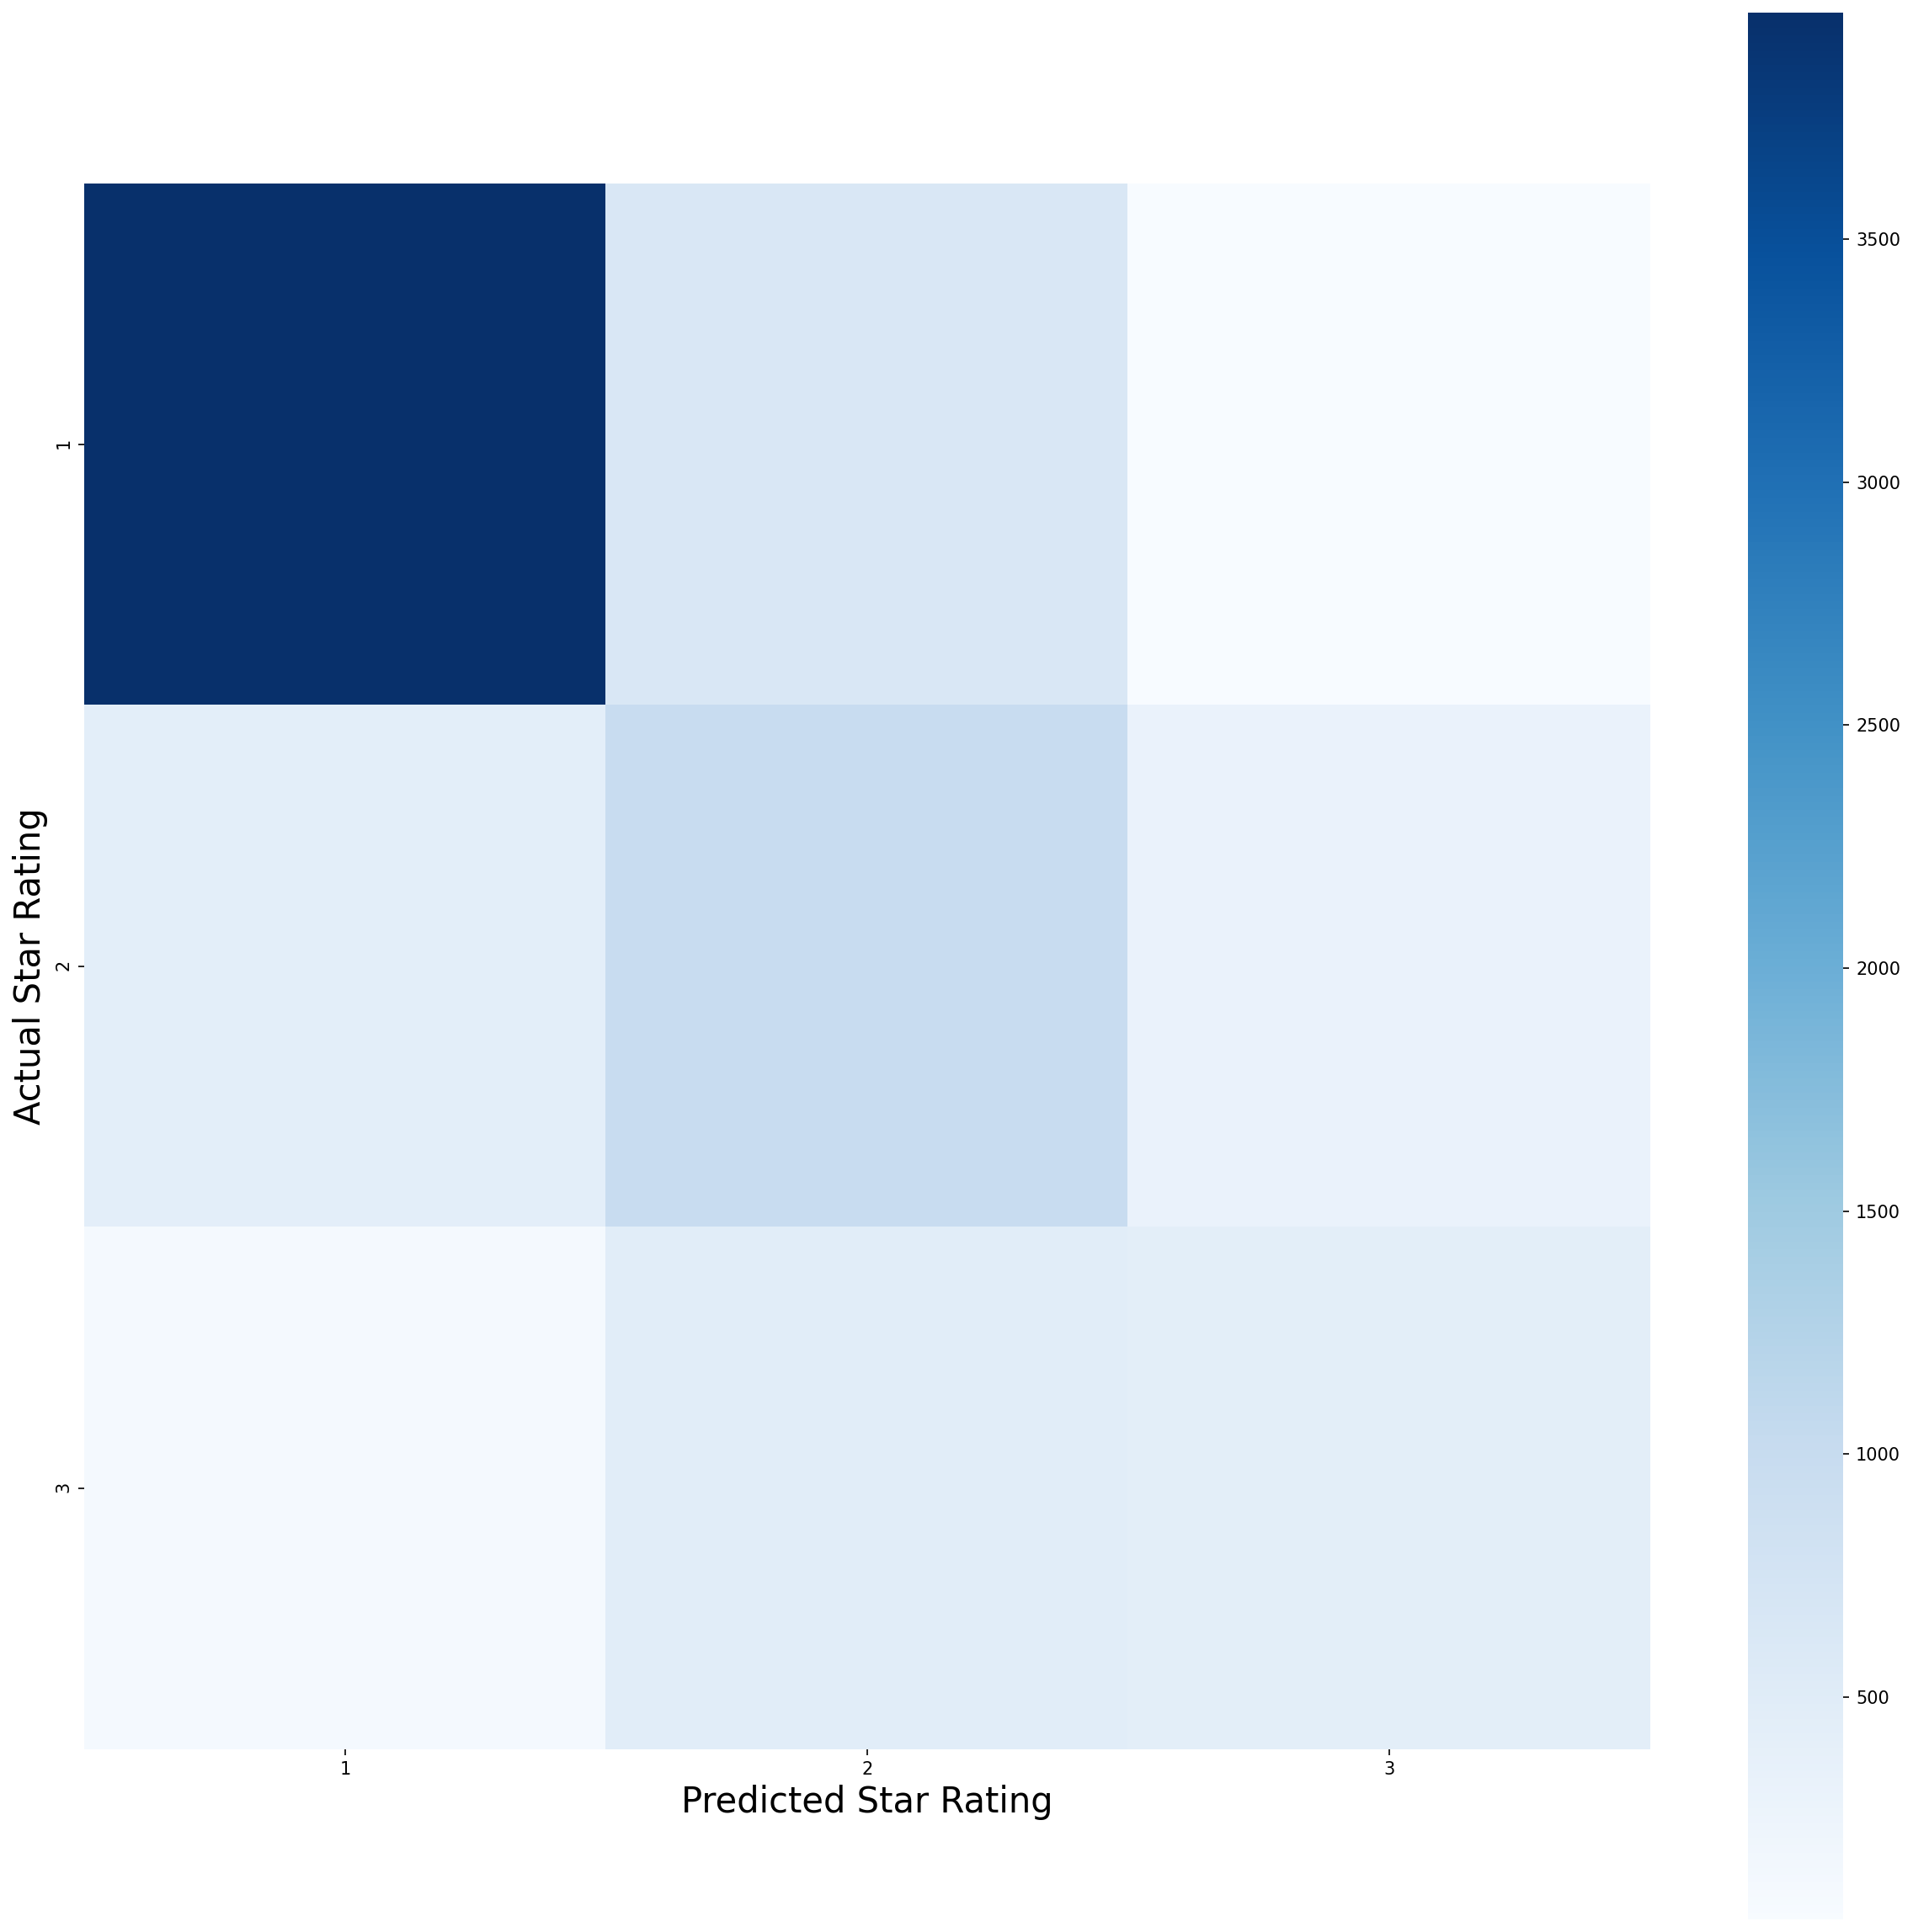

In [163]:
baseline_model2_confusion = confusion_matrix(y_test, y_pred_baseline2)
plt.figure(dpi=150,figsize=(20,20))
sns.heatmap(baseline_model2_confusion, cmap=plt.cm.Blues, square=True, 
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Star Rating", fontsize=20)
plt.ylabel("Actual Star Rating", fontsize=20)
plt.savefig("../Documents/Images/baseline2_confusion_matrix.png",dpi=400);

# Error Analysis
Find 3 predictions the CNN got right that the RF got wrong



    


In [164]:


#my_results = [<index in test_indices>, <correct_cnn_label>, <incorrect_rf_label>]
my_results = []
number_of_examples = 0

for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if number_of_examples == 3:
        break
    
    if (cnn_pred == y_test[idx]) and (y_test[idx] != y_pred_rf[idx]):
        my_results.append([idx, cnn_pred,y_pred_rf[idx]])
        number_of_examples += 1


# Conclusion

In [165]:
my_results

[[1, 2, 0], [3, 1, 0], [4, 1, 0]]

In [166]:
example_indices = testing_indices[my_results[:][0]] 

In [167]:
example_indices

array([20707, 40958, 66902])

In [168]:
pd.options.display.max_colwidth = None

In [169]:
text_of_reviews.iloc[example_indices,:]

,review_title,review_text_original,review_star_rating,review_text,net_promoter_score
724,Absolutely LOVE THIS MOVIE!!!! FAMILY FRIENDLY TREAT!,"In an era with so much inappropriate and disgusting messages in the movie industry, this movie is an absolute treat for me and my family! Clean--no swearing. No blood or gory violence.No sex references or scenes on any gender. The sophistication and level of beauty of a well-written and well-acted movie is a wonderful change. I encourage those to watch it if you are tired of horrible messages in movies. The only thing is the flashbacks may be hard to keep up, just be aware of filters and other indications of the timeline of the movie to notice if it in the past or present. But found the timeline very necessary and suspenful. Lovely movie for me and my family and can't recommend it enough. :):)",9,absolutely love this movie family friendly treat in an era with so much inappropriate and disgusting in the movie industry this movie be an absolute treat for me and my family no blood or gory sex or on any gender the sophistication and level of beauty of a and movie be a wonderful change i encourage those to watch it if you be tire of horrible in the only thing be the may be hard to keep up just be aware of and other of the of the movie to notice if it in the past or present but find the very necessary and lovely movie for me and my family and recommend it enough,2
55608,Good horror flick!,Nell Sweetzer tries to rebuild her life right after the events depicted in the first film. Now living in home for girls she tries to forget the horrific events she experienced only to find out that they are all too real.This is a good sequel to the first in which the demons true intentions are revealed. It uses classic horror tactics and stays away from the traditional exorcism films. The plot was well grounded and the acting specially from Ashley Bell was outstanding. This was not filmed in the found footage style which adds more depth to the story. The ending to this film was definitely my favorite part and I enjoyed this good old fashioned horror flick.I was rather skeptical at first due to the low ratings on IMDb but I keep forgetting that horror films are not for everyone but if you do enjoy them this is a must see!! 7/10.,6,good horror flick to rebuild her life right after the in the first film now live in home for she to forget the horrific she experience only to find out that they be all too be a good sequel to the first in which the true be reveal it classic horror tactic and stay away from the traditional exorcism the plot be well ground and the act specially from bell be outstanding this be not in the found footage style which more depth to the story the end to this film be definitely my favorite part and i this good old fashion horror be rather skeptical at first due to the low on but i keep forget that horror be not for everyone but if you do enjoy them this be a must see,0
15300,Entertaining prison movie,"No doubt that movie is entertaining, 8/10, fast, no slow time. Humour, jokes, a few reference to older movie. This movie is with both main actor, not a Sly movie with a cameo of Arnold, its both of them all the time. It's good and funny. The plot is intelligent, I liked it. It's not a remake of any kind, of course you know the end or you can predict some of the turnouts. But, overall it is fun and intelligent. The ending is rushed a bit, turns out like a bit of a sort of ""Expendable"" style of movie, but not as much. No sex, or any kind of romance in that movie, or super chicks making you want to jump at the screen, it's a typical American movie, blood, guns & some violence, but no chick.",7,entertain prison movie no doubt that movie be entertain fast no slow time humour a few reference to older movie this movie be with both main actor not a sly movie with a cameo of it both of them all the time good and funny the plot be intelligent i it not a remake of any kind of course you know the end o

In [170]:
#Fives where CNN got it right RF got it wrong
Rating = 0
number_of_examples = 5
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred == y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_pred_rf[idx]])
        current_numb += 1



In [171]:
my_results = np.array(my_results)

In [172]:
my_results

array([[3821,    0,    1],
       [5727,    0,    2]])

In [173]:
my_results[:,0]

array([3821, 5727])

In [174]:
example_indices = testing_indices[my_results[:,0]] 

In [175]:
example_indices

array([70867, 12289])

In [176]:
text_of_reviews.iloc[example_indices,:]

review_title  \
1920   Ridley Scott forgot everything about great movies except for the craft   
32825                                                                       4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [177]:
Rating = 9
number_of_examples = 5
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred == y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_pred_rf[idx]])
        current_numb += 1
my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]

[]


IndexError: too many indices for array

In [ ]:
#examples of where CNN got it wrong
Rating = 2
number_of_examples = 3
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred != y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_test[idx]])
        current_numb += 1

my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]

In [ ]:
Rating = 4
number_of_examples = 3
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred != y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_test[idx]])
        current_numb += 1

my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]

In [ ]:
Rating = 1
number_of_examples = 3
current_numb = 0
my_results = []
for idx,cnn_pred in enumerate(y_pred_baseline):
    
    if current_numb == number_of_examples:
        break
    
    if (cnn_pred != y_test[idx]) and (y_test[idx] != y_pred_rf[idx]) and (y_test[idx] == Rating):
        my_results.append([idx, cnn_pred,y_test[idx]])
        current_numb += 1

my_results = np.array(my_results)
print(my_results)
example_indices = testing_indices[my_results[:,0]]

text_of_reviews.iloc[example_indices,:]